## Introdução à Ciência de Dados

### Projeto de Análise Exploratória dos Dados do ENEM-2022 - Análise Exploratória (Projeto 1)

Essa análise está disponível no [Github](https://github.com/jonasrlg/Intro_a_Ciencia_de_Dados_Embraer), contendo tanto *notebook* quanto
*dataset* utilizado. 

In [1]:
import pandas as pd
import polars as pl
import dask.dataframe as dd
import json

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statistics as sts

from scipy.optimize import curve_fit
import scipy.stats as stats
from statsmodels.stats import diagnostic
import statsmodels.api as sm

import gc

### Carregamento do Dataset

Aqui, realizamos uma análise comparativa entre as bibliotecas `pandas`, `dask` e `polars`. A primeira trata-se de uma das bibliotecas mais populares para a Análise de Dados em `Python`; enquanto a segunda e terceira se propõem a possuir uma estrutura similar à primeira, elas também agregam outras funcionalidades, como processamento em múltiplos núcelos. Então utilizamos a primeira como `baseline` para comparar a performance entre as outras duas.

In [2]:
path = 'microdados_enem_2022/DADOS/MICRODADOS_ENEM_2022.csv'

Como nossos datasets serão grandes, deletamos eles após a execução para liberar memória para fazer outras medições de tempo.

In [3]:
gc.collect()

0

In [4]:
%%time
df = pd.read_csv(path, sep=';', encoding='iso8859-1')

CPU times: user 24.6 s, sys: 13.7 s, total: 38.4 s
Wall time: 39.1 s


Salvamos os dados em formato `utf-8` para utilização posterior no `polars`.

In [5]:
df.shape

(3476105, 76)

Armazena `dtype` para todas as colunas de `df`, para que esses tipos sejam usados para carregar o `DataFrame` em `dask` corretamente. Não é usado no `pandas` porque utilizar essa informação não alterou seu tempo de execução para carregamento. Também não é utilizado no `polars`, porque a biblioteca é incapaz de carregar o `DataFrame` quando passamos os `dtypes` correspondentes da biblioteca (`pl.Int64`, `pl.Float64`, `pl.Object`), de modo que foram encontrados problemas para carregar atributos com tipagem de objeto.

In [6]:
df_dtypes = dict(df.dtypes)
df_dtypes

{'NU_INSCRICAO': dtype('int64'),
 'NU_ANO': dtype('int64'),
 'TP_FAIXA_ETARIA': dtype('int64'),
 'TP_SEXO': dtype('O'),
 'TP_ESTADO_CIVIL': dtype('int64'),
 'TP_COR_RACA': dtype('int64'),
 'TP_NACIONALIDADE': dtype('int64'),
 'TP_ST_CONCLUSAO': dtype('int64'),
 'TP_ANO_CONCLUIU': dtype('int64'),
 'TP_ESCOLA': dtype('int64'),
 'TP_ENSINO': dtype('float64'),
 'IN_TREINEIRO': dtype('int64'),
 'CO_MUNICIPIO_ESC': dtype('float64'),
 'NO_MUNICIPIO_ESC': dtype('O'),
 'CO_UF_ESC': dtype('float64'),
 'SG_UF_ESC': dtype('O'),
 'TP_DEPENDENCIA_ADM_ESC': dtype('float64'),
 'TP_LOCALIZACAO_ESC': dtype('float64'),
 'TP_SIT_FUNC_ESC': dtype('float64'),
 'CO_MUNICIPIO_PROVA': dtype('int64'),
 'NO_MUNICIPIO_PROVA': dtype('O'),
 'CO_UF_PROVA': dtype('int64'),
 'SG_UF_PROVA': dtype('O'),
 'TP_PRESENCA_CN': dtype('int64'),
 'TP_PRESENCA_CH': dtype('int64'),
 'TP_PRESENCA_LC': dtype('int64'),
 'TP_PRESENCA_MT': dtype('int64'),
 'CO_PROVA_CN': dtype('float64'),
 'CO_PROVA_CH': dtype('float64'),
 'CO_PROVA_L

In [7]:
for key, val in df_dtypes.items():
    df_dtypes[key] = str(val)
df_dtypes

{'NU_INSCRICAO': 'int64',
 'NU_ANO': 'int64',
 'TP_FAIXA_ETARIA': 'int64',
 'TP_SEXO': 'object',
 'TP_ESTADO_CIVIL': 'int64',
 'TP_COR_RACA': 'int64',
 'TP_NACIONALIDADE': 'int64',
 'TP_ST_CONCLUSAO': 'int64',
 'TP_ANO_CONCLUIU': 'int64',
 'TP_ESCOLA': 'int64',
 'TP_ENSINO': 'float64',
 'IN_TREINEIRO': 'int64',
 'CO_MUNICIPIO_ESC': 'float64',
 'NO_MUNICIPIO_ESC': 'object',
 'CO_UF_ESC': 'float64',
 'SG_UF_ESC': 'object',
 'TP_DEPENDENCIA_ADM_ESC': 'float64',
 'TP_LOCALIZACAO_ESC': 'float64',
 'TP_SIT_FUNC_ESC': 'float64',
 'CO_MUNICIPIO_PROVA': 'int64',
 'NO_MUNICIPIO_PROVA': 'object',
 'CO_UF_PROVA': 'int64',
 'SG_UF_PROVA': 'object',
 'TP_PRESENCA_CN': 'int64',
 'TP_PRESENCA_CH': 'int64',
 'TP_PRESENCA_LC': 'int64',
 'TP_PRESENCA_MT': 'int64',
 'CO_PROVA_CN': 'float64',
 'CO_PROVA_CH': 'float64',
 'CO_PROVA_LC': 'float64',
 'CO_PROVA_MT': 'float64',
 'NU_NOTA_CN': 'float64',
 'NU_NOTA_CH': 'float64',
 'NU_NOTA_LC': 'float64',
 'NU_NOTA_MT': 'float64',
 'TX_RESPOSTAS_CN': 'object',
 '

In [8]:
df.to_csv('dados.csv', index=False)
json.dump(df_dtypes, open('dados_dtypes.json', 'w'))

In [9]:
del df
del df_dtypes
gc.collect()

32

Sem a utilização dos `dtypes`, a rotina de inferência do  `dask` não funciona e acabamos recebendo erros na hora de realizar funções `compute` mais a frente

In [10]:
%%time
df = dd.read_csv(path, dtype=json.load(open('dados_dtypes.json')), sep=';', encoding='iso8859-1')

CPU times: user 13.7 ms, sys: 10.5 ms, total: 24.2 ms
Wall time: 33.3 ms


A biblioteca `dask` utiliza *lazy-computing*, então temos que calcular a operação de `shape`, para fazermos um `count` do número de linhas

In [11]:
%%time
shape = df.shape
shape[0].compute(), shape[1]

CPU times: user 1min 8s, sys: 10.7 s, total: 1min 18s
Wall time: 32.1 s


(3476105, 76)

In [12]:
del df
gc.collect()

0

Um grande ponto negativo do polars está na sua expressividade. A biblioteca foi incapaz de processar os dados por estarem em formatação diferente de `utf-8` e seus outros poucos formatos suportados.

A solução encontrada foi salvar o arquivo em `utf-8` usando `pandas` e chamar novamente pelo `polar`, o que não é a solução mais desejável.

In [2]:
%%time
df = pl.read_csv('dados.csv')

CPU times: user 15.3 s, sys: 19.5 s, total: 34.9 s
Wall time: 5.75 s


In [3]:
df.shape

(3476105, 76)

In [4]:
del df
gc.collect()

0

Aqui, foi possível ver que, nesse conjunto de dados com `3.4 milhões` de instâncias, a utilização de uma ferramente de dados em paralelo não conseguiu acelerar o carreganmento dos dados de maneira satisfatória. A *lazy-computation*  do `dask` acabou não sendo muito efeciente, já que o carregamento foi rápido, mas uma simples operação de `count` tomou quase o dobro do tempo do carregamento da *baseline*, usando  `pandas`. Similarmente, não foi observada uma melhora significativa ao utilizarmos uma ferramente como  `polars`, além dos seus problemas de compatibilidade com outros formatos.

Vale notar que, num *dataset* considervalmente menor, ENEM-2016, tanto `polars` quanto `dask` se sairam bem, diminuindo o tempo de `0.2 segundos` para `0.1 segundos`. Entretanto, quando aumentamos no número de instâncias e fizemos essa análise assintótica, não observamos tal fenômeno, de modo que até demoraram mais tempo que o `pandas` para o conjunto de dados ENEM-2022.

Quando utilizei o conjunto de dados ENEM-2016, É esperado que esse comportamento assintótico seja ainda mais bem visível conforme aumentamos o tamanho das instâncias dos dados (seja esse aumento em relação ao número de linhas e/ou colunas do *dataset*).

### Seleção de variáveis

Seguiremos com a utilização do `pandas` no restante do programa, já que, mesmo essa sendo ferramenta sequencial para manipulação de dados, vimos que seu desempenho no carregamento do dataset (e outros testes de seleção que não foram incluídos no notebook por questões de readability) foi similar ao das outras bibliotecas para este caso. Além disso, temos que, por ser uma ferramenta mais popular, mais pessoas estão acostumadas com suas funcionalidades e sua documentação é mais difundida.

Por fim, também temos a maturidade da ferramenta, que, embora não seja a mais veloz, possui diferentes funcções de análise em conjunto com documentação/tutoriais extensivos.

In [2]:
df = pd.read_csv('dados.csv', dtype=json.load(open('dados_dtypes.json')))

In [3]:
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [4]:
# Checando que todos os números de inscrição são diferentes
df['NU_INSCRICAO'].is_unique

True

In [5]:
# Checando que todos os dados são referentes ao ano de 2022
df['NU_ANO'].eq(2022).all()

True

Aqui, verficamos se as colunas de códigos e nomes são equivalentes.

In [6]:
(df['CO_MUNICIPIO_ESC'].isna() == df['NO_MUNICIPIO_ESC'].isna()).eq(True).all()

True

In [7]:
(df['CO_UF_ESC'].isna() == df['SG_UF_ESC'].isna()).eq(True).all()

True

In [8]:
(df['CO_MUNICIPIO_PROVA'].isna() == df['NO_MUNICIPIO_PROVA'].isna()).eq(True).all()

True

In [9]:
(df['CO_UF_PROVA'].isna() == df['SG_UF_PROVA'].isna()).eq(True).all()

True

Colunas `NU_INSCRICAO` e `NU_ANO` não proporcionam muita informação. O Número de Inscrição serve como um identificador, mas podemos utilizar os próprios índices do `DataFrame` como identificação; já o Número do Ano da prova é inútil, porque sabemos que todas elas são de 2022.

Em seguida, verificamos acima que os códigos não nos trazem informações relevantes, já que podemos usar os nomes das cidades e estados, o que é muito mais facilmente interpretável. Segundamente, também não selecionamos variáveis do tipo ``CO_PROVA_`, já que essas se referem os códigos das provas (cor azul, amarela, rosa, cinza, etc).

In [10]:
enem = df[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 
          'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
          'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 
          'TP_SIT_FUNC_ESC', 'NO_MUNICIPIO_PROVA','SG_UF_PROVA', 'TP_PRESENCA_CN', 
          'TP_PRESENCA_CH', 'TP_PRESENCA_LC','TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH',
          'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 
          'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 
          'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO', 
          'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1', 
          'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 
          'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008',
          'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 
          'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']]
enem.shape

(3476105, 70)

As primeiras variváveis do tipo `TP_` e as últimas do tipo `Q` referem-se à questões socio-econômicas do candidato (estado civiil, escola pública ou não, acesso à internet, etc).

Variáveis `NO` e `SG`referem-se a nomes e siglas de cidades e estados, respectivamente. Enquanto vriáveis do tipo `TX_RESPOSTAS_` e `TX_GABARITO_` são vetores com as respostas dos alunos das partes objetivas e seus respectivos gabaritos.

Já dados começados por `NU` são as notas das provas objetivas, múltipla escolha; e os dados `NOTA` estão relacionados a um dos conceitos da avaliação de redação. Associado a essas provas temos `TP_PRESENCA`, `TP_LINGUA` e `TP_STATUS_REDACAO` estão relacionados à presença dx alunx na prova respectiva. 

In [18]:
enem_dtypes = dict(enem.dtypes)
enem_dtypes

{'TP_FAIXA_ETARIA': dtype('int64'),
 'TP_SEXO': dtype('O'),
 'TP_ESTADO_CIVIL': dtype('int64'),
 'TP_COR_RACA': dtype('int64'),
 'TP_NACIONALIDADE': dtype('int64'),
 'TP_ST_CONCLUSAO': dtype('int64'),
 'TP_ANO_CONCLUIU': dtype('int64'),
 'TP_ESCOLA': dtype('int64'),
 'TP_ENSINO': dtype('float64'),
 'IN_TREINEIRO': dtype('int64'),
 'NO_MUNICIPIO_ESC': dtype('O'),
 'SG_UF_ESC': dtype('O'),
 'TP_DEPENDENCIA_ADM_ESC': dtype('float64'),
 'TP_LOCALIZACAO_ESC': dtype('float64'),
 'TP_SIT_FUNC_ESC': dtype('float64'),
 'NO_MUNICIPIO_PROVA': dtype('O'),
 'SG_UF_PROVA': dtype('O'),
 'TP_PRESENCA_CN': dtype('int64'),
 'TP_PRESENCA_CH': dtype('int64'),
 'TP_PRESENCA_LC': dtype('int64'),
 'TP_PRESENCA_MT': dtype('int64'),
 'CO_PROVA_CN': dtype('float64'),
 'CO_PROVA_CH': dtype('float64'),
 'CO_PROVA_LC': dtype('float64'),
 'CO_PROVA_MT': dtype('float64'),
 'TX_RESPOSTAS_CN': dtype('O'),
 'TX_RESPOSTAS_CH': dtype('O'),
 'TX_RESPOSTAS_LC': dtype('O'),
 'TX_RESPOSTAS_MT': dtype('O'),
 'TP_LINGUA': dtyp

In [19]:
for key, val in enem_dtypes.items():
    enem_dtypes[key] = str(val)
enem_dtypes

{'TP_FAIXA_ETARIA': 'int64',
 'TP_SEXO': 'object',
 'TP_ESTADO_CIVIL': 'int64',
 'TP_COR_RACA': 'int64',
 'TP_NACIONALIDADE': 'int64',
 'TP_ST_CONCLUSAO': 'int64',
 'TP_ANO_CONCLUIU': 'int64',
 'TP_ESCOLA': 'int64',
 'TP_ENSINO': 'float64',
 'IN_TREINEIRO': 'int64',
 'NO_MUNICIPIO_ESC': 'object',
 'SG_UF_ESC': 'object',
 'TP_DEPENDENCIA_ADM_ESC': 'float64',
 'TP_LOCALIZACAO_ESC': 'float64',
 'TP_SIT_FUNC_ESC': 'float64',
 'NO_MUNICIPIO_PROVA': 'object',
 'SG_UF_PROVA': 'object',
 'TP_PRESENCA_CN': 'int64',
 'TP_PRESENCA_CH': 'int64',
 'TP_PRESENCA_LC': 'int64',
 'TP_PRESENCA_MT': 'int64',
 'CO_PROVA_CN': 'float64',
 'CO_PROVA_CH': 'float64',
 'CO_PROVA_LC': 'float64',
 'CO_PROVA_MT': 'float64',
 'TX_RESPOSTAS_CN': 'object',
 'TX_RESPOSTAS_CH': 'object',
 'TX_RESPOSTAS_LC': 'object',
 'TX_RESPOSTAS_MT': 'object',
 'TP_LINGUA': 'int64',
 'TX_GABARITO_CN': 'object',
 'TX_GABARITO_CH': 'object',
 'TX_GABARITO_LC': 'object',
 'TX_GABARITO_MT': 'object',
 'TP_STATUS_REDACAO': 'float64',
 'NU

In [22]:
enem.to_csv('enem.csv', index=False)
json.dump(enem_dtypes, open('enem_dtypes.json', 'w'))

In [23]:
# Deletamos o dataset original por ocupar muito espaço
del df
del enem
gc.collect()

140

### Análise, Limpeza e Transformação do DataFrame

Utilizando a análise de dados das colunas relevantes (checando com o documento oficial de dicionário de variáveis em  `microdados_enem_2022/DICIONARIO`), foi possível eliminar 8 colunas do dataset. Ou seja, aproximadamente 10% das colunas do dataset original não continham informações relevantes, analisando o significado das colunas que foi explciitado por algum especialista do domínio. 

Além disso, vale notar que metade das variáveis são do tipo `Q`, categóricas que podem ser cruzadas facilmente dados de municípios, estados ou notas, já que referem-se à questões socio-econômicas daqueles que se inscreveram nas provas.

In [2]:
enem = pd.read_csv('enem.csv', dtype=json.load(open('enem_dtypes.json')))

In [3]:
# Visualização de uma pequena amostra dos dados
enem.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,14,M,2,2,1,1,2,1,NaN,0,...,B,A,A,A,A,A,A,A,A,A
1,14,M,2,1,1,1,16,1,NaN,0,...,E,E,B,E,B,B,E,B,E,B
2,5,F,1,2,1,1,2,1,NaN,0,...,A,A,A,A,A,A,C,A,A,B
3,6,M,1,3,1,1,2,1,NaN,0,...,B,A,A,C,A,A,C,B,B,B
4,4,M,0,3,1,1,1,1,NaN,0,...,A,A,A,A,A,A,B,A,A,A


In [4]:
# Visualização de algumas estatísticas referente às colunas 
describe = enem.describe()
describe

,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,...,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005
count,3.476105e+06,3.476105e+06,3.476105e+06,3.476105e+06,3.476105e+06,3.476105e+06,3.476105e+06,1.262744e+06,3.476105e+06,951944.000000,...,2.493442e+06,2.493442e+06,2.355395e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,3.476105e+06
mean,4.863503e+00,1.042771e+00,2.035284e+00,1.028641e+00,1.684877e+00,2.178502e+00,1.440080e+00,1.005993e+00,1.475019e-01,2.435363,...,5.269531e+02,5.174389e+02,5.425032e+02,1.193923e+02,1.409609e+02,1.148686e+02,1.294384e+02,1.138195e+02,6.184797e+02,3.745322e+00
std,3.690560e+00,3.873107e-01,1.019759e+00,2.102919e-01,7.297286e-01,4.064238e+00,6.070447e-01,7.717901e-02,3.546056e-01,0.909683,...,8.148446e+01,7.755491e+01,1.160225e+02,3.700626e+01,5.353708e+01,4.102659e+01,4.268095e+01,5.982160e+01,2.122125e+02,1.376848e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000,...,4.770000e+02,4.684000e+02,4.490000e+02,1.000000e+02,1.200000e+02,1.000000e+02,1.200000e+02,8.000000e+01,5.200000e+02,3.000000e+00
50%,3.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000,...,5.299000e+02,5.255000e+02,5.308000e+02,1.200000e+02,1.400000e+02,1.200000e+02,1.200000e+02,1.200000e+02,6.200000e+02,4.000000e+00
75%,6.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.000000,...,5.819000e+02,5.732000e+02,6.224000e+02,1.400000e+02,2.000000e+02,1.400000e+02,1.600000e+02,1.600000e+02,7.600000e+02,4.000000e+00
max,2.000000e+01,4.000000e+00,5.000000e+00,4.000000e+00,4.000000e+00,1.600000e+01,3.000000e+00,2.000000e+00,1.000000e+00,4.000000,...,8.392000e+02,8.010000e+02,9.857000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,1.000000e+03,2.000000e+01


Agora, analisamos cada uma das colunas selecionadas, de modo que podemos quais colunas possuem dados faltantes, sua quantidade, se essa coluna é relevante para a nossa análise, e quantos dados serão perdidos nesse processo.

In [5]:
info = pd.DataFrame({'tipos':enem.dtypes, 'missing':enem.isna().sum()})
info

,tipos,missing
TP_FAIXA_ETARIA,int64,0
TP_SEXO,object,0
TP_ESTADO_CIVIL,int64,0
TP_COR_RACA,int64,0
TP_NACIONALIDADE,int64,0
...,...,...
Q021,object,0
Q022,object,0
Q023,object,0
Q024,object,0


In [6]:
for index, value in info['missing'].items():
    print(f'{index}: {value}')

TP_FAIXA_ETARIA: 0
TP_SEXO: 0
TP_ESTADO_CIVIL: 0
TP_COR_RACA: 0
TP_NACIONALIDADE: 0
TP_ST_CONCLUSAO: 0
TP_ANO_CONCLUIU: 0
TP_ESCOLA: 0
TP_ENSINO: 2213361
IN_TREINEIRO: 0
NO_MUNICIPIO_ESC: 2524161
SG_UF_ESC: 2524161
TP_DEPENDENCIA_ADM_ESC: 2524161
TP_LOCALIZACAO_ESC: 2524161
TP_SIT_FUNC_ESC: 2524161
NO_MUNICIPIO_PROVA: 0
SG_UF_PROVA: 0
TP_PRESENCA_CN: 0
TP_PRESENCA_CH: 0
TP_PRESENCA_LC: 0
TP_PRESENCA_MT: 0
CO_PROVA_CN: 1120710
CO_PROVA_CH: 982663
CO_PROVA_LC: 982663
CO_PROVA_MT: 1120710
TX_RESPOSTAS_CN: 1120710
TX_RESPOSTAS_CH: 982663
TX_RESPOSTAS_LC: 982663
TX_RESPOSTAS_MT: 1120710
TP_LINGUA: 0
TX_GABARITO_CN: 1120710
TX_GABARITO_CH: 982663
TX_GABARITO_LC: 982663
TX_GABARITO_MT: 1120710
TP_STATUS_REDACAO: 982663
NU_NOTA_CN: 1120710
NU_NOTA_CH: 982663
NU_NOTA_LC: 982663
NU_NOTA_MT: 1120710
NU_NOTA_COMP1: 982663
NU_NOTA_COMP2: 982663
NU_NOTA_COMP3: 982663
NU_NOTA_COMP4: 982663
NU_NOTA_COMP5: 982663
NU_NOTA_REDACAO: 982663
Q001: 0
Q002: 0
Q003: 0
Q004: 0
Q005: 0
Q006: 0
Q007: 0
Q008: 0
Q0

Aqui, podemos ver que existe uma quantidade expressiva de dados faltantes no nosso dataset.

Colunas de questões socio-econômicas ou outras foram todas preenchidas por fazerem parte do processo de inscrição, mas principalmente variáveis relacionadas às notas estão faltando (`NU_NOTA`,  `TX_RESPOSTAS/GABARITOS`, entre outras).

In [7]:
info['missing'].max()/enem.shape[0]*100

72.61463620920541

Mesmo se jogarmos fora todos os dados faltantes, note que teremos acesso ainda assim a uma quantidade expressiva de dados, próximo da casa do milhão. Mas não seguiremos fazendo esse drop de forma indiscriminada. Somente faremos isso para as colunas selecionadas em cada parte da análise

In [8]:
enem.dropna().shape[0]

681900

#### Agora, seguimos com um tratamento das variáveis qualitativas

In [9]:
enem['TP_FAIXA_ETARIA']

0          14
1          14
2           5
3           6
4           4
           ..
3476100     3
3476101    14
3476102     2
3476103     3
3476104     2
Name: TP_FAIXA_ETARIA, Length: 3476105, dtype: int64

In [10]:
enem['TP_FAIXA_ETARIA'] = enem['TP_FAIXA_ETARIA'].map({ 1:	'Menor de 17 anos',
                                                        2:	'17 anos',
                                                        3:	'18 anos',
                                                        4:	'19 anos',
                                                        5:	'20 anos',
                                                        6:	'21 anos',
                                                        7:	'22 anos',
                                                        8:	'23 anos',
                                                        9:	'24 anos',
                                                        10:	'25 anos',
                                                        11:	'Entre 26 e 30 anos',
                                                        12:	'Entre 31 e 35 anos',
                                                        13:	'Entre 36 e 40 anos',
                                                        14:	'Entre 41 e 45 anos',
                                                        15:	'Entre 46 e 50 anos',
                                                        16:	'Entre 51 e 55 anos',
                                                        17:	'Entre 56 e 60 anos',
                                                        18:	'Entre 61 e 65 anos',
                                                        19:	'Entre 66 e 70 anos',
                                                        20:	'Maior de 70 anos'
                                                    })
enem['TP_FAIXA_ETARIA']

0          Entre 41 e 45 anos
1          Entre 41 e 45 anos
2                     20 anos
3                     21 anos
4                     19 anos
                  ...        
3476100               18 anos
3476101    Entre 41 e 45 anos
3476102               17 anos
3476103               18 anos
3476104               17 anos
Name: TP_FAIXA_ETARIA, Length: 3476105, dtype: object

In [11]:
enem['TP_SEXO']

0          M
1          M
2          F
3          M
4          M
          ..
3476100    M
3476101    F
3476102    M
3476103    M
3476104    F
Name: TP_SEXO, Length: 3476105, dtype: object

In [12]:
enem['TP_SEXO'] = enem['TP_SEXO'].map({'M':	'Masculino', 'F': 'Feminino'})
enem['TP_SEXO']

0          Masculino
1          Masculino
2           Feminino
3          Masculino
4          Masculino
             ...    
3476100    Masculino
3476101     Feminino
3476102    Masculino
3476103    Masculino
3476104     Feminino
Name: TP_SEXO, Length: 3476105, dtype: object

In [13]:
enem['TP_ESTADO_CIVIL']

0          2
1          2
2          1
3          1
4          0
          ..
3476100    1
3476101    2
3476102    1
3476103    1
3476104    2
Name: TP_ESTADO_CIVIL, Length: 3476105, dtype: int64

In [14]:
enem['TP_ESTADO_CIVIL'] = enem['TP_ESTADO_CIVIL'].map({ 0:	'Não informado',
                                                        1:	'Solteiro(a)',
                                                        2:	'Casado(a)/Mora com companheiro(a)',
                                                        3:	'Divorciado(a)/Desquitado(a)/Separado(a)',
                                                        4:	'Viúvo(a)'
                                                    })
enem['TP_ESTADO_CIVIL']

0          Casado(a)/Mora com companheiro(a)
1          Casado(a)/Mora com companheiro(a)
2                                Solteiro(a)
3                                Solteiro(a)
4                              Não informado
                         ...                
3476100                          Solteiro(a)
3476101    Casado(a)/Mora com companheiro(a)
3476102                          Solteiro(a)
3476103                          Solteiro(a)
3476104    Casado(a)/Mora com companheiro(a)
Name: TP_ESTADO_CIVIL, Length: 3476105, dtype: object

In [15]:
enem['TP_COR_RACA']

0          2
1          1
2          2
3          3
4          3
          ..
3476100    1
3476101    1
3476102    1
3476103    3
3476104    3
Name: TP_COR_RACA, Length: 3476105, dtype: int64

In [16]:
enem['TP_COR_RACA'] = enem['TP_COR_RACA'].map({ 0:	'Não declarado',
                                                1:	'Branca',
                                                2:	'Preta',
                                                3:	'Parda',
                                                4:	'Amarela',
                                                5:	'Indígena ',
                                                6:	'Não dispõe da informação'
                                            })
enem['TP_COR_RACA']

0           Preta
1          Branca
2           Preta
3           Parda
4           Parda
            ...  
3476100    Branca
3476101    Branca
3476102    Branca
3476103     Parda
3476104     Parda
Name: TP_COR_RACA, Length: 3476105, dtype: object

In [17]:
enem['TP_NACIONALIDADE']

0          1
1          1
2          1
3          1
4          1
          ..
3476100    1
3476101    1
3476102    1
3476103    1
3476104    1
Name: TP_NACIONALIDADE, Length: 3476105, dtype: int64

In [18]:
enem['TP_NACIONALIDADE'] = enem['TP_NACIONALIDADE'].map({ 0:	'Não informado',
                                                          1:	'Brasileiro(a)',
                                                          2:	'Brasileiro(a) Naturalizado(a)',
                                                          3:	'Estrangeiro(a)',
                                                          4:	'Brasileiro(a) Nato(a), nascido(a) no exterior'
                                                    })
enem['TP_NACIONALIDADE']

0          Brasileiro(a)
1          Brasileiro(a)
2          Brasileiro(a)
3          Brasileiro(a)
4          Brasileiro(a)
               ...      
3476100    Brasileiro(a)
3476101    Brasileiro(a)
3476102    Brasileiro(a)
3476103    Brasileiro(a)
3476104    Brasileiro(a)
Name: TP_NACIONALIDADE, Length: 3476105, dtype: object

In [19]:
enem['TP_ST_CONCLUSAO']

0          1
1          1
2          1
3          1
4          1
          ..
3476100    2
3476101    2
3476102    2
3476103    2
3476104    2
Name: TP_ST_CONCLUSAO, Length: 3476105, dtype: int64

In [20]:
enem['TP_ST_CONCLUSAO'] = enem['TP_ST_CONCLUSAO'].map({ 1:	'Já concluí o Ensino Médio',
                                                        2:	'Estou cursando e concluirei o Ensino Médio em 2022',
                                                        3:	'Estou cursando e concluirei o Ensino Médio após 2022',
                                                        4:	'Não concluí e não estou cursando o Ensino Médio'
                                                    })
enem['TP_ST_CONCLUSAO']

0                                  Já concluí o Ensino Médio
1                                  Já concluí o Ensino Médio
2                                  Já concluí o Ensino Médio
3                                  Já concluí o Ensino Médio
4                                  Já concluí o Ensino Médio
                                 ...                        
3476100    Estou cursando e concluirei o Ensino Médio em ...
3476101    Estou cursando e concluirei o Ensino Médio em ...
3476102    Estou cursando e concluirei o Ensino Médio em ...
3476103    Estou cursando e concluirei o Ensino Médio em ...
3476104    Estou cursando e concluirei o Ensino Médio em ...
Name: TP_ST_CONCLUSAO, Length: 3476105, dtype: object

In [21]:
enem['TP_ANO_CONCLUIU']

0           2
1          16
2           2
3           2
4           1
           ..
3476100     0
3476101     0
3476102     0
3476103     0
3476104     0
Name: TP_ANO_CONCLUIU, Length: 3476105, dtype: int64

In [22]:
enem['TP_ANO_CONCLUIU'] = enem['TP_ANO_CONCLUIU'].map({ 0:	'Não informado',
                                                        1:	'2021',
                                                        2:	'2020',
                                                        3:	'2019',
                                                        4:	'2018',
                                                        5:	'2017',
                                                        6:	'2016',
                                                        7:	'2015',
                                                        8:	'2014',
                                                        9:	'2013',
                                                        10:	'2012',
                                                        11:	'2011',
                                                        12:	'2010',
                                                        13:	'2009',
                                                        14:	'2008',
                                                        15:	'2007',
                                                        16:	'Antes de 2007'
                                                    })
enem['TP_ANO_CONCLUIU']

0                   2020
1          Antes de 2007
2                   2020
3                   2020
4                   2021
               ...      
3476100    Não informado
3476101    Não informado
3476102    Não informado
3476103    Não informado
3476104    Não informado
Name: TP_ANO_CONCLUIU, Length: 3476105, dtype: object

In [23]:
enem['TP_ESCOLA']

0          1
1          1
2          1
3          1
4          1
          ..
3476100    2
3476101    2
3476102    2
3476103    3
3476104    2
Name: TP_ESCOLA, Length: 3476105, dtype: int64

In [24]:
enem['TP_ESCOLA'] = enem['TP_ESCOLA'].map({ 1:	'Não Respondeu',
                                            2:	'Pública',
                                            3:	'Privada'
                                        })
enem['TP_ESCOLA']

0          Não Respondeu
1          Não Respondeu
2          Não Respondeu
3          Não Respondeu
4          Não Respondeu
               ...      
3476100          Pública
3476101          Pública
3476102          Pública
3476103          Privada
3476104          Pública
Name: TP_ESCOLA, Length: 3476105, dtype: object

In [25]:
enem['TP_ENSINO']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3476100    1.0
3476101    NaN
3476102    1.0
3476103    1.0
3476104    1.0
Name: TP_ENSINO, Length: 3476105, dtype: float64

In [26]:
enem['TP_ENSINO'] = enem['TP_ENSINO'].map({ 1:	'Ensino Regular',
                                            2:	'Educação Especial - Modalidade Substitutiva'
})
enem['TP_ENSINO']

0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                ...      
3476100    Ensino Regular
3476101               NaN
3476102    Ensino Regular
3476103    Ensino Regular
3476104    Ensino Regular
Name: TP_ENSINO, Length: 3476105, dtype: object

In [27]:
enem['IN_TREINEIRO']

0          0
1          0
2          0
3          0
4          0
          ..
3476100    0
3476101    0
3476102    0
3476103    0
3476104    0
Name: IN_TREINEIRO, Length: 3476105, dtype: int64

In [28]:
enem['IN_TREINEIRO'] = enem['IN_TREINEIRO'].map({1:	'Sim', 0: 'Não'})
enem['IN_TREINEIRO']

0          Não
1          Não
2          Não
3          Não
4          Não
          ... 
3476100    Não
3476101    Não
3476102    Não
3476103    Não
3476104    Não
Name: IN_TREINEIRO, Length: 3476105, dtype: object

In [29]:
enem['TP_DEPENDENCIA_ADM_ESC']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3476100    NaN
3476101    2.0
3476102    2.0
3476103    4.0
3476104    2.0
Name: TP_DEPENDENCIA_ADM_ESC, Length: 3476105, dtype: float64

In [30]:
enem['TP_DEPENDENCIA_ADM_ESC'] = enem['TP_DEPENDENCIA_ADM_ESC'].map({ 1:	'Federal',
                                                                      2:	'Estadual',
                                                                      3:	'Municipal',
                                                                      4:	'Privada'
                                                                    })
enem['TP_DEPENDENCIA_ADM_ESC']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
3476100         NaN
3476101    Estadual
3476102    Estadual
3476103     Privada
3476104    Estadual
Name: TP_DEPENDENCIA_ADM_ESC, Length: 3476105, dtype: object

In [31]:
enem['TP_LOCALIZACAO_ESC']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3476100    NaN
3476101    1.0
3476102    1.0
3476103    1.0
3476104    1.0
Name: TP_LOCALIZACAO_ESC, Length: 3476105, dtype: float64

In [32]:
enem['TP_LOCALIZACAO_ESC'] = enem['TP_LOCALIZACAO_ESC'].map({ 1:	'Urbana',
                                                              2:	'Rural'
                                                            })
enem['TP_LOCALIZACAO_ESC']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
            ...  
3476100       NaN
3476101    Urbana
3476102    Urbana
3476103    Urbana
3476104    Urbana
Name: TP_LOCALIZACAO_ESC, Length: 3476105, dtype: object

In [33]:
enem['TP_SIT_FUNC_ESC']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3476100    NaN
3476101    1.0
3476102    1.0
3476103    1.0
3476104    1.0
Name: TP_SIT_FUNC_ESC, Length: 3476105, dtype: float64

In [34]:
enem['TP_SIT_FUNC_ESC'] = enem['TP_SIT_FUNC_ESC'].map({ 1:	'Em atividade',
                                                        2:	'Paralisada',
                                                        3:	'Extinta',
                                                        4:	'Escola extinta em anos anteriores.'
                                                    })
enem['TP_SIT_FUNC_ESC']

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
               ...     
3476100             NaN
3476101    Em atividade
3476102    Em atividade
3476103    Em atividade
3476104    Em atividade
Name: TP_SIT_FUNC_ESC, Length: 3476105, dtype: object

In [35]:
enem['TP_PRESENCA_CN']

0          0
1          0
2          1
3          1
4          0
          ..
3476100    0
3476101    0
3476102    1
3476103    0
3476104    0
Name: TP_PRESENCA_CN, Length: 3476105, dtype: int64

In [36]:
enem['TP_PRESENCA_CN'] = enem['TP_PRESENCA_CN'].map({ 0:	'Faltou à prova',
                                                      1:	'Presente na prova',
                                                      2:	'Eliminado na prova'
                                                    })
enem['TP_PRESENCA_CN']

0             Faltou à prova
1             Faltou à prova
2          Presente na prova
3          Presente na prova
4             Faltou à prova
                 ...        
3476100       Faltou à prova
3476101       Faltou à prova
3476102    Presente na prova
3476103       Faltou à prova
3476104       Faltou à prova
Name: TP_PRESENCA_CN, Length: 3476105, dtype: object

In [37]:
enem['TP_PRESENCA_CH']

0          0
1          0
2          1
3          1
4          0
          ..
3476100    0
3476101    0
3476102    1
3476103    0
3476104    0
Name: TP_PRESENCA_CH, Length: 3476105, dtype: int64

In [38]:
enem['TP_PRESENCA_CH'] = enem['TP_PRESENCA_CH'].map({ 0:	'Faltou à prova',
                                                      1:	'Presente na prova',
                                                      2:	'Eliminado na prova'
                                                    })
enem['TP_PRESENCA_CH']

0             Faltou à prova
1             Faltou à prova
2          Presente na prova
3          Presente na prova
4             Faltou à prova
                 ...        
3476100       Faltou à prova
3476101       Faltou à prova
3476102    Presente na prova
3476103       Faltou à prova
3476104       Faltou à prova
Name: TP_PRESENCA_CH, Length: 3476105, dtype: object

In [39]:
enem['TP_PRESENCA_LC']

0          0
1          0
2          1
3          1
4          0
          ..
3476100    0
3476101    0
3476102    1
3476103    0
3476104    0
Name: TP_PRESENCA_LC, Length: 3476105, dtype: int64

In [40]:
enem['TP_PRESENCA_LC'] = enem['TP_PRESENCA_LC'].map({ 0:	'Faltou à prova',
                                                      1:	'Presente na prova',
                                                      2:	'Eliminado na prova'
                                                    })
enem['TP_PRESENCA_LC']

0             Faltou à prova
1             Faltou à prova
2          Presente na prova
3          Presente na prova
4             Faltou à prova
                 ...        
3476100       Faltou à prova
3476101       Faltou à prova
3476102    Presente na prova
3476103       Faltou à prova
3476104       Faltou à prova
Name: TP_PRESENCA_LC, Length: 3476105, dtype: object

In [41]:
enem['TP_PRESENCA_MT']

0          0
1          0
2          1
3          1
4          0
          ..
3476100    0
3476101    0
3476102    1
3476103    0
3476104    0
Name: TP_PRESENCA_MT, Length: 3476105, dtype: int64

In [42]:
enem['TP_PRESENCA_MT'] = enem['TP_PRESENCA_MT'].map({ 0:	'Faltou à prova',
                                                      1:	'Presente na prova',
                                                      2:	'Eliminado na prova'
                                                    })
enem['TP_PRESENCA_MT']

0             Faltou à prova
1             Faltou à prova
2          Presente na prova
3          Presente na prova
4             Faltou à prova
                 ...        
3476100       Faltou à prova
3476101       Faltou à prova
3476102    Presente na prova
3476103       Faltou à prova
3476104       Faltou à prova
Name: TP_PRESENCA_MT, Length: 3476105, dtype: object

In [43]:
enem['CO_PROVA_CN']

0             NaN
1             NaN
2          1087.0
3          1088.0
4             NaN
            ...  
3476100       NaN
3476101       NaN
3476102    1085.0
3476103       NaN
3476104       NaN
Name: CO_PROVA_CN, Length: 3476105, dtype: float64

In [44]:
enem['CO_PROVA_CN'] = enem['CO_PROVA_CN'].map({ 1085:	'Azul',
                                                1086:	'Amarela',
                                                1087:	'Cinza',
                                                1088:	'Rosa',
                                                1092:	'Laranja - Adaptada Ledor',
                                                1093:	'Verde - Videoprova - Libras',
                                                1165:	'Azul (Reaplicação)',
                                                1166:	'Amarela (Reaplicação)',
                                                1167:	'Cinza (Reaplicação)',
                                                1168:	'Rosa (Reaplicação)',
                                                1187:	'Azul (Digital)',
                                                1188:	'Amarela (Digital)',
                                                1189:	'Rosa (Digital)',
                                                1190:	'Cinza (Digital)'
                                            })
enem['CO_PROVA_CN']

0            NaN
1            NaN
2          Cinza
3           Rosa
4            NaN
           ...  
3476100      NaN
3476101      NaN
3476102     Azul
3476103      NaN
3476104      NaN
Name: CO_PROVA_CN, Length: 3476105, dtype: object

In [45]:
enem['CO_PROVA_CH']

0             NaN
1             NaN
2          1056.0
3          1058.0
4             NaN
            ...  
3476100       NaN
3476101       NaN
3476102    1057.0
3476103       NaN
3476104       NaN
Name: CO_PROVA_CH, Length: 3476105, dtype: float64

In [46]:
enem['CO_PROVA_CH'] = enem['CO_PROVA_CH'].map({ 1055:	'Azul',
                                                1056:	'Amarela',
                                                1057:	'Cinza',
                                                1058:	'Rosa',
                                                1062:	'Laranja - Adaptada Ledor',
                                                1063:	'Verde - Videoprova - Libras',
                                                1135:	'Azul (Reaplicação)',
                                                1136:	'Amarela (Reaplicação)',
                                                1137:	'Cinza (Reaplicação)',
                                                1138:	'Rosa (Reaplicação)',
                                                1175:	'Azul (Digital)',
                                                1176:	'Amarela (Digital)',
                                                1177:	'Rosa (Digital)',
                                                1178:	'Cinza (Digital)'
                                            })
enem['CO_PROVA_CH']

0              NaN
1              NaN
2          Amarela
3             Rosa
4              NaN
            ...   
3476100        NaN
3476101        NaN
3476102      Cinza
3476103        NaN
3476104        NaN
Name: CO_PROVA_CH, Length: 3476105, dtype: object

In [47]:
enem['CO_PROVA_LC']

0             NaN
1             NaN
2          1066.0
3          1067.0
4             NaN
            ...  
3476100       NaN
3476101       NaN
3476102    1068.0
3476103       NaN
3476104       NaN
Name: CO_PROVA_LC, Length: 3476105, dtype: float64

In [48]:
enem['CO_PROVA_LC'] = enem['CO_PROVA_LC'].map({ 1065:	'Azul',
                                                1066:	'Amarela',
                                                1067:	'Cinza',
                                                1068:	'Rosa',
                                                1072:	'Laranja - Adaptada Ledor',
                                                1073:	'Verde - Videoprova - Libras',
                                                1145:	'Azul (Reaplicação)',
                                                1146:	'Amarela (Reaplicação)',
                                                1147:	'Cinza (Reaplicação)',
                                                1148:	'Rosa (Reaplicação)',
                                                1179:	'Azul (Digital)',
                                                1180:	'Amarela (Digital)',
                                                1181:	'Rosa (Digital)',
                                                1182:	'Cinza (Digital)'
                                            })
enem['CO_PROVA_LC']

0              NaN
1              NaN
2          Amarela
3            Cinza
4              NaN
            ...   
3476100        NaN
3476101        NaN
3476102       Rosa
3476103        NaN
3476104        NaN
Name: CO_PROVA_LC, Length: 3476105, dtype: object

In [49]:
enem['CO_PROVA_MT'] = enem['CO_PROVA_MT'].map({ 1075:	'Azul',
                                                1076:	'Amarela',
                                                1077:	'Cinza',
                                                1078:	'Rosa',
                                                1082:	'Laranja - Adaptada Ledor',
                                                1083:	'Verde - Videoprova - Libras',
                                                1155:	'Azul (Reaplicação)',
                                                1156:	'Amarela (Reaplicação)',
                                                1157:	'Cinza (Reaplicação)',
                                                1158:	'Rosa (Reaplicação)',
                                                1183:	'Azul (Digital)',
                                                1184:	'Amarela (Digital)',
                                                1185:	'Rosa (Digital)',
                                                1186:	'Cinza (Digital)'
                                            })
enem['CO_PROVA_MT']

0            NaN
1            NaN
2           Rosa
3          Cinza
4            NaN
           ...  
3476100      NaN
3476101      NaN
3476102     Azul
3476103      NaN
3476104      NaN
Name: CO_PROVA_MT, Length: 3476105, dtype: object

In [50]:
enem['TP_LINGUA']

0          0
1          0
2          1
3          1
4          0
          ..
3476100    1
3476101    1
3476102    0
3476103    0
3476104    1
Name: TP_LINGUA, Length: 3476105, dtype: int64

In [51]:
enem['TP_LINGUA'] = enem['TP_LINGUA'].map({ 0:	'Inglês',
                                            1:	'Espanhol'
                                        })
enem['TP_LINGUA']

0            Inglês
1            Inglês
2          Espanhol
3          Espanhol
4            Inglês
             ...   
3476100    Espanhol
3476101    Espanhol
3476102      Inglês
3476103      Inglês
3476104    Espanhol
Name: TP_LINGUA, Length: 3476105, dtype: object

In [52]:
enem['TP_STATUS_REDACAO']

0          NaN
1          NaN
2          1.0
3          1.0
4          NaN
          ... 
3476100    NaN
3476101    NaN
3476102    1.0
3476103    NaN
3476104    NaN
Name: TP_STATUS_REDACAO, Length: 3476105, dtype: float64

In [53]:
enem['TP_STATUS_REDACAO'] = enem['TP_STATUS_REDACAO'].map({ 1:	'Sem problemas',
                                                            2:	'Anulada',
                                                            3:	'Cópia Texto Motivador',
                                                            4:	'Em Branco',
                                                            6:	'Fuga ao tema',
                                                            7:	'Não atendimento ao tipo textual',
                                                            8:	'Texto insuficiente',
                                                            9:	'Parte desconectada'
                                                        })
enem['TP_STATUS_REDACAO']

0                    NaN
1                    NaN
2          Sem problemas
3          Sem problemas
4                    NaN
               ...      
3476100              NaN
3476101              NaN
3476102    Sem problemas
3476103              NaN
3476104              NaN
Name: TP_STATUS_REDACAO, Length: 3476105, dtype: object

In [54]:
enem['Q001']

0          A
1          D
2          E
3          C
4          D
          ..
3476100    D
3476101    A
3476102    E
3476103    H
3476104    A
Name: Q001, Length: 3476105, dtype: object

In [55]:
enem['Q001'] = enem['Q001'].map({ 'A':	'Nunca estudou.',
                                  'B':	'Não completou a 4ª série/5º ano do Ensino Fundamental.',
                                  'C':	'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.',
                                  'D':	'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.',
                                  'E':	'Completou o Ensino Médio, mas não completou a Faculdade.',
                                  'F':	'Completou a Faculdade, mas não completou a Pós-graduação.',
                                  'G':	'Completou a Pós-graduação.',
                                  'H':	'Não sei.'
                                })
enem['Q001']

0                                             Nunca estudou.
1          Completou a 8ª série/9º ano do Ensino Fundamen...
2          Completou o Ensino Médio, mas não completou a ...
3          Completou a 4ª série/5º ano, mas não completou...
4          Completou a 8ª série/9º ano do Ensino Fundamen...
                                 ...                        
3476100    Completou a 8ª série/9º ano do Ensino Fundamen...
3476101                                       Nunca estudou.
3476102    Completou o Ensino Médio, mas não completou a ...
3476103                                             Não sei.
3476104                                       Nunca estudou.
Name: Q001, Length: 3476105, dtype: object

In [56]:
enem['Q002']

0          A
1          D
2          F
3          A
4          B
          ..
3476100    E
3476101    A
3476102    C
3476103    F
3476104    A
Name: Q002, Length: 3476105, dtype: object

In [57]:
enem['Q002'] = enem['Q002'].map({ 'A':	'Nunca estudou.',
                                  'B':	'Não completou a 4ª série/5º ano do Ensino Fundamental.',
                                  'C':	'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.',
                                  'D':	'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.',
                                  'E':	'Completou o Ensino Médio, mas não completou a Faculdade.',
                                  'F':	'Completou a Faculdade, mas não completou a Pós-graduação.',
                                  'G':	'Completou a Pós-graduação.',
                                  'H':	'Não sei.'
                                })
enem['Q002']

0                                             Nunca estudou.
1          Completou a 8ª série/9º ano do Ensino Fundamen...
2          Completou a Faculdade, mas não completou a Pós...
3                                             Nunca estudou.
4          Não completou a 4ª série/5º ano do Ensino Fund...
                                 ...                        
3476100    Completou o Ensino Médio, mas não completou a ...
3476101                                       Nunca estudou.
3476102    Completou a 4ª série/5º ano, mas não completou...
3476103    Completou a Faculdade, mas não completou a Pós...
3476104                                       Nunca estudou.
Name: Q002, Length: 3476105, dtype: object

In [58]:
enem['Q003']

0          A
1          E
2          A
3          A
4          A
          ..
3476100    B
3476101    A
3476102    C
3476103    F
3476104    B
Name: Q003, Length: 3476105, dtype: object

In [59]:
enem['Q003'] = enem['Q003'].map({ 'A':	'Grupo 1: Lavrador, agricultor sem empregados, bóia fria, criador de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultor, pescador, lenhador, seringueiro, extrativista.',
                                  'B':	'Grupo 2: Diarista, empregado doméstico, cuidador de idosos, babá, cozinheiro (em casas particulares), motorista particular, jardineiro, faxineiro de empresas e prédios, vigilante, porteiro, carteiro, office-boy, vendedor, caixa, atendente de loja, auxiliar administrativo, recepcionista, servente de pedreiro, repositor de mercadoria.',
                                  'C':	'Grupo 3: Padeiro, cozinheiro industrial ou em restaurantes, sapateiro, costureiro, joalheiro, torneiro mecânico, operador de máquinas, soldador, operário de fábrica, trabalhador da mineração, pedreiro, pintor, eletricista, encanador, motorista, caminhoneiro, taxista.',
                                  'D':	'Grupo 4: Professor (de ensino fundamental ou médio, idioma, música, artes etc.), técnico (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretor de imóveis, supervisor, gerente, mestre de obras, pastor, microempresário (proprietário de empresa com menos de 10 empregados), pequeno comerciante, pequeno proprietário de terras, trabalhador autônomo ou por conta própria.',
                                  'E':	'Grupo 5: Médico, engenheiro, dentista, psicólogo, economista, advogado, juiz, promotor, defensor, delegado, tenente, capitão, coronel, professor universitário, diretor em empresas públicas ou privadas, político, proprietário de empresas com mais de 10 empregados.',
                                  'F':	'Não sei.'
                                })
enem['Q003']

0          Grupo 1: Lavrador, agricultor sem empregados, ...
1          Grupo 5: Médico, engenheiro, dentista, psicólo...
2          Grupo 1: Lavrador, agricultor sem empregados, ...
3          Grupo 1: Lavrador, agricultor sem empregados, ...
4          Grupo 1: Lavrador, agricultor sem empregados, ...
                                 ...                        
3476100    Grupo 2: Diarista, empregado doméstico, cuidad...
3476101    Grupo 1: Lavrador, agricultor sem empregados, ...
3476102    Grupo 3: Padeiro, cozinheiro industrial ou em ...
3476103                                             Não sei.
3476104    Grupo 2: Diarista, empregado doméstico, cuidad...
Name: Q003, Length: 3476105, dtype: object

In [60]:
enem['Q004']

0          B
1          E
2          D
3          B
4          B
          ..
3476100    B
3476101    A
3476102    B
3476103    B
3476104    B
Name: Q004, Length: 3476105, dtype: object

In [61]:
enem['Q004'] = enem['Q004'].map({ 'A':	'Grupo 1: Lavradora, agricultora sem empregados, bóia fria, criadora de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultora, pescadora, lenhadora, seringueira, extrativista.',
                                  'B':	'Grupo 2: Diarista, empregada doméstica, cuidadora de idosos, babá, cozinheira (em casas particulares), motorista particular, jardineira, faxineira de empresas e prédios, vigilante, porteira, carteira, office-boy, vendedora, caixa, atendente de loja, auxiliar administrativa, recepcionista, servente de pedreiro, repositora de mercadoria.',
                                  'C':	'Grupo 3: Padeira, cozinheira industrial ou em restaurantes, sapateira, costureira, joalheira, torneira mecânica, operadora de máquinas, soldadora, operária de fábrica, trabalhadora da mineração, pedreira, pintora, eletricista, encanadora, motorista, caminhoneira, taxista.',
                                  'D':	'Grupo 4: Professora (de ensino fundamental ou médio, idioma, música, artes etc.), técnica (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretora de imóveis, supervisora, gerente, mestre de obras, pastora, microempresária (proprietária de empresa com menos de 10 empregados), pequena comerciante, pequena proprietária de terras, trabalhadora autônoma ou por conta própria.',
                                  'E':	'Grupo 5: Médica, engenheira, dentista, psicóloga, economista, advogada, juíza, promotora, defensora, delegada, tenente, capitã, coronel, professora universitária, diretora em empresas públicas ou privadas, política, proprietária de empresas com mais de 10 empregados.',
                                  'F':	'Não sei.'
                                })
enem['Q004']

0          Grupo 2: Diarista, empregada doméstica, cuidad...
1          Grupo 5: Médica, engenheira, dentista, psicólo...
2          Grupo 4: Professora (de ensino fundamental ou ...
3          Grupo 2: Diarista, empregada doméstica, cuidad...
4          Grupo 2: Diarista, empregada doméstica, cuidad...
                                 ...                        
3476100    Grupo 2: Diarista, empregada doméstica, cuidad...
3476101    Grupo 1: Lavradora, agricultora sem empregados...
3476102    Grupo 2: Diarista, empregada doméstica, cuidad...
3476103    Grupo 2: Diarista, empregada doméstica, cuidad...
3476104    Grupo 2: Diarista, empregada doméstica, cuidad...
Name: Q004, Length: 3476105, dtype: object

In [62]:
enem['Q005']

0          3
1          3
2          2
3          3
4          2
          ..
3476100    4
3476101    3
3476102    4
3476103    5
3476104    2
Name: Q005, Length: 3476105, dtype: int64

In [63]:
enem['Q005'] = enem['Q005'].map({ 1:	'1, pois moro sozinho(a).',
                                  2:	'2',
                                  3:	'3',
                                  4:	'4',
                                  5:	'5',
                                  6:	'6',
                                  7:	'7',
                                  8:	'8',
                                  9:	'9',
                                  10:	'10',
                                  11:	'11',
                                  12:	'12',
                                  13:	'13',
                                  14:	'14',
                                  15:	'15',
                                  16:	'16',
                                  17:	'17',
                                  18:	'18',
                                  19:	'19',
                                  20:	'20'
                                })
enem['Q005']

0          3
1          3
2          2
3          3
4          2
          ..
3476100    4
3476101    3
3476102    4
3476103    5
3476104    2
Name: Q005, Length: 3476105, dtype: object

In [64]:
enem['Q006']

0          B
1          Q
2          B
3          A
4          B
          ..
3476100    F
3476101    B
3476102    G
3476103    E
3476104    B
Name: Q006, Length: 3476105, dtype: object

In [65]:
enem['Q006'] = enem['Q006'].map({ 'A':	'Nenhuma Renda',
                                  'B':	'Até R$ 1.212,00',
                                  'C':	'De R$ 1.212,01 até R$ 1.818,00.',
                                  'D':	'De R$ 1.818,01 até R$ 2.424,00.',
                                  'E':	'De R$ 2.424,01 até R$ 3.030,00.',
                                  'F':	'De R$ 3.030,01 até R$ 3.636,00.',
                                  'G':	'De R$ 3.636,01 até R$ 4.848,00.',
                                  'H':	'De R$ 4.848,01 até R$ 6.060,00.',
                                  'I':	'De R$ 6.060,01 até R$ 7.272,00.',
                                  'J':	'De R$ 7.272,01 até R$ 8.484,00.',
                                  'K':	'De R$ 8.484,01 até R$ 9.696,00.',
                                  'L':	'De R$ 9.696,01 até R$ 10.908,00.',
                                  'M':	'De R$ 10.908,01 até R$ 12.120,00.',
                                  'N':	'De R$ 12.120,01 até R$ 14.544,00.',
                                  'O':	'De R$ 14.544,01 até R$ 18.180,00.',
                                  'P':	'De R$ 18.180,01 até R$ 24.240,00.',
                                  'Q':	'Acima de R$ 24.240,00.'
                                })
enem['Q006']

0                          Até R$ 1.212,00
1                   Acima de R$ 24.240,00.
2                          Até R$ 1.212,00
3                            Nenhuma Renda
4                          Até R$ 1.212,00
                        ...               
3476100    De R$ 3.030,01 até R$ 3.636,00.
3476101                    Até R$ 1.212,00
3476102    De R$ 3.636,01 até R$ 4.848,00.
3476103    De R$ 2.424,01 até R$ 3.030,00.
3476104                    Até R$ 1.212,00
Name: Q006, Length: 3476105, dtype: object

In [66]:
enem['Q007']

0          B
1          D
2          A
3          A
4          A
          ..
3476100    A
3476101    A
3476102    A
3476103    A
3476104    A
Name: Q007, Length: 3476105, dtype: object

In [67]:
enem['Q007'] = enem['Q007'].map({ 'A':	'Não.',
                                  'B':	'Sim, um ou dois dias por semana.',
                                  'C':	'Sim, três ou quatro dias por semana.',
                                  'D':	'Sim, pelo menos cinco dias por semana.'
                                })
enem['Q007']

0                Sim, um ou dois dias por semana.
1          Sim, pelo menos cinco dias por semana.
2                                            Não.
3                                            Não.
4                                            Não.
                            ...                  
3476100                                      Não.
3476101                                      Não.
3476102                                      Não.
3476103                                      Não.
3476104                                      Não.
Name: Q007, Length: 3476105, dtype: object

In [68]:
um = ['08', '09', '10', '13', '16', '22', '24']
um_dic = { 'A':	'Não.',
           'B':	'Sim, um.',
           'C':	'Sim, dois.',
           'D':	'Sim, três.',
           'E':	'Sim, quatro ou mais.'
}

for num in um:
    aux = 'Q0' + num
    enem[aux] = enem[aux].map(um_dic)

In [69]:
uma = ['11', '12', '14', '15', '17', '19']
uma_dic = { 'A':	'Não.',
            'B':	'Sim, uma.',
            'C':	'Sim, duas.',
            'D':	'Sim, três.',
            'E':	'Sim, quatro ou mais.'
}

for num in uma:
    aux = 'Q0' + num
    enem[aux] = enem[aux].map(uma_dic)

In [70]:
sem = ['18', '20', '21', '23', '25']
sem_dic = {'A':	'Não.', 'B':	'Sim.'}

for num in sem:
    aux = 'Q0' + num
    enem[aux] = enem[aux].map(sem_dic)

Agora, o dataset está mais interpretável, já que usamos os dicionários de variáveis para transformar os dados.

In [71]:
enemx_dtypes = dict(enem.dtypes)
enemx_dtypes

{'TP_FAIXA_ETARIA': dtype('O'),
 'TP_SEXO': dtype('O'),
 'TP_ESTADO_CIVIL': dtype('O'),
 'TP_COR_RACA': dtype('O'),
 'TP_NACIONALIDADE': dtype('O'),
 'TP_ST_CONCLUSAO': dtype('O'),
 'TP_ANO_CONCLUIU': dtype('O'),
 'TP_ESCOLA': dtype('O'),
 'TP_ENSINO': dtype('O'),
 'IN_TREINEIRO': dtype('O'),
 'NO_MUNICIPIO_ESC': dtype('O'),
 'SG_UF_ESC': dtype('O'),
 'TP_DEPENDENCIA_ADM_ESC': dtype('O'),
 'TP_LOCALIZACAO_ESC': dtype('O'),
 'TP_SIT_FUNC_ESC': dtype('O'),
 'NO_MUNICIPIO_PROVA': dtype('O'),
 'SG_UF_PROVA': dtype('O'),
 'TP_PRESENCA_CN': dtype('O'),
 'TP_PRESENCA_CH': dtype('O'),
 'TP_PRESENCA_LC': dtype('O'),
 'TP_PRESENCA_MT': dtype('O'),
 'CO_PROVA_CN': dtype('O'),
 'CO_PROVA_CH': dtype('O'),
 'CO_PROVA_LC': dtype('O'),
 'CO_PROVA_MT': dtype('O'),
 'TX_RESPOSTAS_CN': dtype('O'),
 'TX_RESPOSTAS_CH': dtype('O'),
 'TX_RESPOSTAS_LC': dtype('O'),
 'TX_RESPOSTAS_MT': dtype('O'),
 'TP_LINGUA': dtype('O'),
 'TX_GABARITO_CN': dtype('O'),
 'TX_GABARITO_CH': dtype('O'),
 'TX_GABARITO_LC': dtype('

In [72]:
for key, val in enemx_dtypes.items():
    enemx_dtypes[key] = str(val)
enemx_dtypes

{'TP_FAIXA_ETARIA': 'object',
 'TP_SEXO': 'object',
 'TP_ESTADO_CIVIL': 'object',
 'TP_COR_RACA': 'object',
 'TP_NACIONALIDADE': 'object',
 'TP_ST_CONCLUSAO': 'object',
 'TP_ANO_CONCLUIU': 'object',
 'TP_ESCOLA': 'object',
 'TP_ENSINO': 'object',
 'IN_TREINEIRO': 'object',
 'NO_MUNICIPIO_ESC': 'object',
 'SG_UF_ESC': 'object',
 'TP_DEPENDENCIA_ADM_ESC': 'object',
 'TP_LOCALIZACAO_ESC': 'object',
 'TP_SIT_FUNC_ESC': 'object',
 'NO_MUNICIPIO_PROVA': 'object',
 'SG_UF_PROVA': 'object',
 'TP_PRESENCA_CN': 'object',
 'TP_PRESENCA_CH': 'object',
 'TP_PRESENCA_LC': 'object',
 'TP_PRESENCA_MT': 'object',
 'CO_PROVA_CN': 'object',
 'CO_PROVA_CH': 'object',
 'CO_PROVA_LC': 'object',
 'CO_PROVA_MT': 'object',
 'TX_RESPOSTAS_CN': 'object',
 'TX_RESPOSTAS_CH': 'object',
 'TX_RESPOSTAS_LC': 'object',
 'TX_RESPOSTAS_MT': 'object',
 'TP_LINGUA': 'object',
 'TX_GABARITO_CN': 'object',
 'TX_GABARITO_CH': 'object',
 'TX_GABARITO_LC': 'object',
 'TX_GABARITO_MT': 'object',
 'TP_STATUS_REDACAO': 'object',


In [74]:
enem.to_csv('enem_explained.csv', index=False)
json.dump(enemx_dtypes, open('enem_explained_dtypes.json', 'w'))

In [75]:
del enem
del enemx_dtypes
gc.collect()

32

### Análise Exploratória

In [2]:
enemx = pd.read_csv('enem_explained.csv', dtype=json.load(open('enem_explained_dtypes.json')))

In [3]:
enemx.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,Entre 41 e 45 anos,Masculino,Casado(a)/Mora com companheiro(a),Preta,Brasileiro(a),Já concluí o Ensino Médio,2020,Não Respondeu,NaN,Não,...,"Sim, um.",Não.,Não.,Não.,Não.,Não.,Não.,Não.,Não.,Não.
1,Entre 41 e 45 anos,Masculino,Casado(a)/Mora com companheiro(a),Branca,Brasileiro(a),Já concluí o Ensino Médio,Antes de 2007,Não Respondeu,NaN,Não,...,"Sim, quatro ou mais.","Sim, quatro ou mais.",Sim.,"Sim, quatro ou mais.",Sim.,Sim.,"Sim, quatro ou mais.",Sim.,"Sim, quatro ou mais.",Sim.
2,20 anos,Feminino,Solteiro(a),Preta,Brasileiro(a),Já concluí o Ensino Médio,2020,Não Respondeu,NaN,Não,...,Não.,Não.,Não.,Não.,Não.,Não.,"Sim, dois.",Não.,Não.,Sim.
3,21 anos,Masculino,Solteiro(a),Parda,Brasileiro(a),Já concluí o Ensino Médio,2020,Não Respondeu,NaN,Não,...,"Sim, um.",Não.,Não.,"Sim, duas.",Não.,Não.,"Sim, dois.",Sim.,"Sim, um.",Sim.
4,19 anos,Masculino,Não informado,Parda,Brasileiro(a),Já concluí o Ensino Médio,2021,Não Respondeu,NaN,Não,...,Não.,Não.,Não.,Não.,Não.,Não.,"Sim, um.",Não.,Não.,Não.


Claro, armazenar os dados dessa maneira, usando strings, é extremamente mais custoso em questão de espaço. Mas vale notar que somente fizemos isso para as variáveis categóricas, que agora estão extremamente mais explicativas, facilitando a análise, elaboração de gráficos e outras questões de visualização como um todo, sem que seja necessário a criação de dicionários para fazer a bijeção entre o que os números significam e seu correspondente no dicionários de variáveis.

#### Análise nas proporções de inscritos

TP_SEXO
Feminino     61.002732
Masculino    38.997268
Name: count, dtype: float64


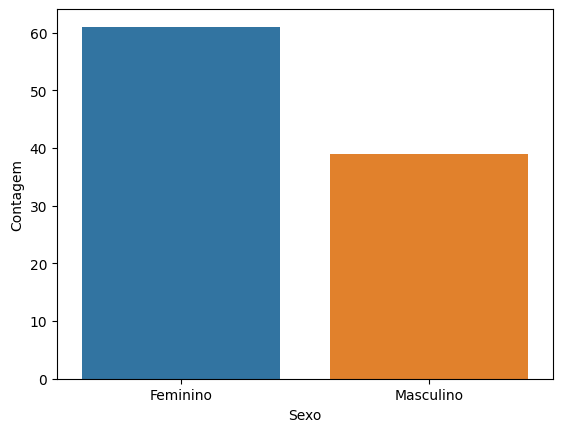

In [20]:
sexo = enemx['TP_SEXO'].value_counts()/enemx['TP_SEXO'].count()*100
print(sexo)
sns.barplot(x=sexo.index, y=sexo)
plt.xlabel('Sexo')
plt.ylabel("Contagem")
plt.show()

Podemos observar que a proporção de mulheres inscritas na prova é consideravelmente mais alta que a de homens.

TP_SEXO
Feminino     61.269785
Masculino    38.730215
Name: count, dtype: float64


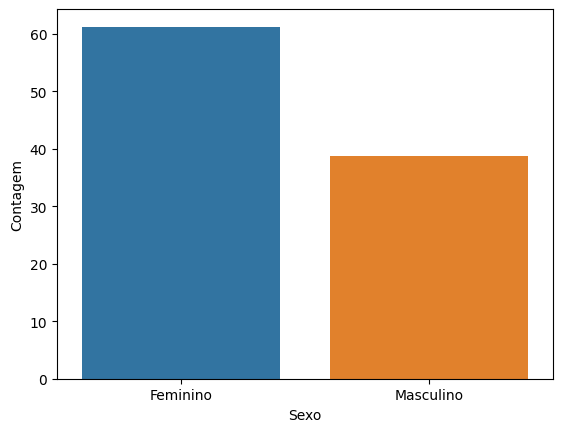

In [21]:
aux = enemx.loc[(enemx['TP_PRESENCA_CN'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_CH'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_LC'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_MT'] == 'Presente na prova'), ['TP_SEXO']]
sexo_presenca = aux['TP_SEXO'].value_counts()/aux['TP_SEXO'].count()*100
print(sexo_presenca)
sns.barplot(x=sexo_presenca.index, y=sexo_presenca)
plt.xlabel('Sexo')
plt.ylabel("Contagem")
plt.show()

Além disso, a proporção de mulheres e homens que fizeram as provas é a mesma, na prática

TP_COR_RACA
Parda            42.830812
Branca           41.082792
Preta            11.749415
Amarela           1.900144
Não declarado     1.866083
Indígena          0.570754
Name: count, dtype: float64


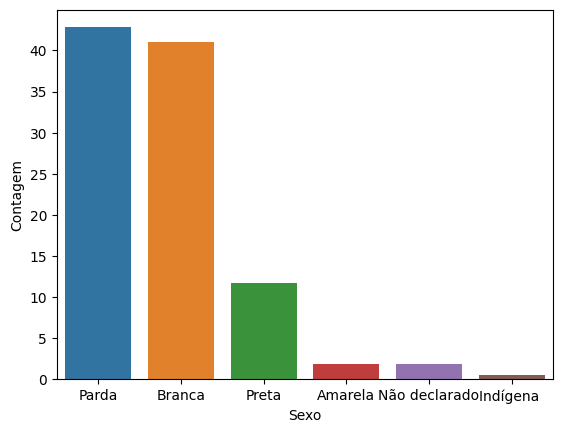

In [23]:
cor = enemx['TP_COR_RACA'].value_counts()/enemx['TP_COR_RACA'].count()*100
print(cor)
sns.barplot(x=cor.index, y=cor)
plt.xlabel('Sexo')
plt.ylabel("Contagem")
plt.show()

TP_COR_RACA
Branca           43.773794
Parda            41.226907
Preta            10.911826
Amarela           1.867177
Não declarado     1.743031
Indígena          0.477264
Name: count, dtype: float64


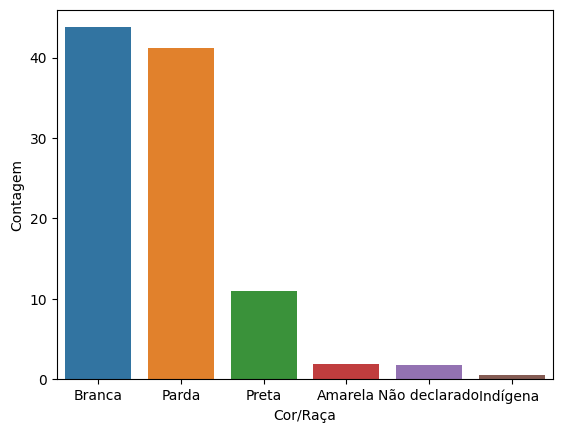

In [22]:
aux = enemx.loc[(enemx['TP_PRESENCA_CN'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_CH'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_LC'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_MT'] == 'Presente na prova'), ['TP_COR_RACA']]
cor_presenca = aux['TP_COR_RACA'].value_counts()/aux['TP_COR_RACA'].count()*100
print(cor_presenca)
sns.barplot(x=cor_presenca.index, y=cor_presenca)
plt.xlabel('Cor/Raça')
plt.ylabel("Contagem")
plt.show()

Similarmente aos resultados para sexo, temos que a distribuição de inscritos e pessoas que fizeram a prova são semelhantes para o ENEM-2022. Mas o número de brancos que conseguiram fazer a prova troca a proporção em relação aos pardos.

Q025
Sim.    90.610957
Não.     9.389043
Name: count, dtype: float64


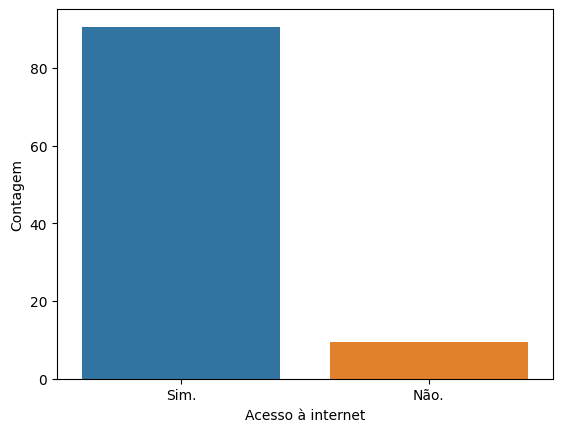

In [25]:
internet = enemx['Q025'].value_counts()/enemx['Q025'].count()*100
print(internet)
sns.barplot(x=internet.index, y=internet)
plt.xlabel('Acesso à internet')
plt.ylabel("Contagem")
plt.show()

Q025
Sim.    91.958753
Não.     8.041247
Name: count, dtype: float64


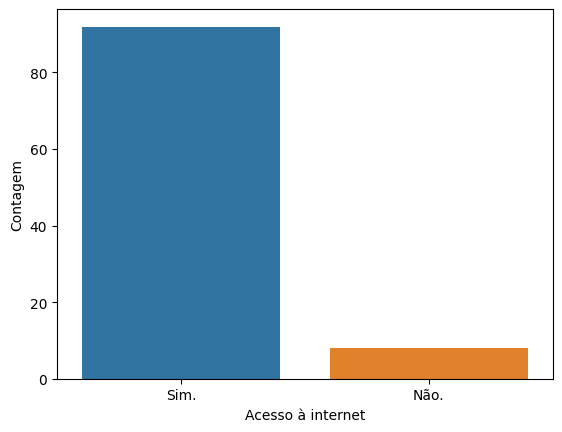

In [27]:
aux = enemx.loc[(enemx['TP_PRESENCA_CN'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_CH'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_LC'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_MT'] == 'Presente na prova'), ['Q025']]
internet_presenca = aux['Q025'].value_counts()/aux['Q025'].count()*100
print(internet_presenca)
sns.barplot(x=internet_presenca.index, y=internet_presenca)
plt.xlabel('Acesso à internet')
plt.ylabel("Contagem")
plt.show()

Algo similar ao gráfico anterior, podemos ver uma relação de questões socio-econômicas (como é categorizado o tipo da variável em questão) com a frequência em todas as provas. É uma variação sútil, mas, ao considerarmos a grande quantidade de pessoas que realizam o exame, essa variação encontra-se na casa dos milhares.

Q006
Até R$ 1.212,00                      29.425722
De R$ 1.212,01 até R$ 1.818,00.      16.808411
De R$ 1.818,01 até R$ 2.424,00.      11.917534
De R$ 2.424,01 até R$ 3.030,00.       7.960174
Nenhuma Renda                         5.882302
De R$ 3.636,01 até R$ 4.848,00.       5.590136
De R$ 4.848,01 até R$ 6.060,00.       5.429957
De R$ 3.030,01 até R$ 3.636,00.       4.547935
De R$ 6.060,01 até R$ 7.272,00.       2.270242
De R$ 7.272,01 até R$ 8.484,00.       1.581770
De R$ 9.696,01 até R$ 10.908,00.      1.475646
Acima de R$ 24.240,00.                1.430912
De R$ 10.908,01 até R$ 12.120,00.     1.396103
De R$ 14.544,01 até R$ 18.180,00.     1.122924
De R$ 8.484,01 até R$ 9.696,00.       1.121859
De R$ 18.180,01 até R$ 24.240,00.     1.036562
De R$ 12.120,01 até R$ 14.544,00.     1.001811
Name: count, dtype: float64


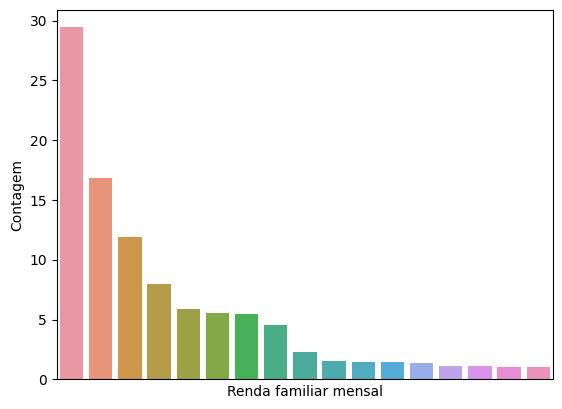

In [55]:
renda = enemx['Q006'].value_counts()/enemx['Q006'].count()*100
print(renda)
sns.barplot(x=renda.index, y=renda)
plt.xlabel('Renda familiar mensal')
plt.xticks([])
plt.ylabel("Contagem")
plt.show()

Q006
Até R$ 1.212,00                      26.888682
De R$ 1.212,01 até R$ 1.818,00.      15.766819
De R$ 1.818,01 até R$ 2.424,00.      11.804900
De R$ 2.424,01 até R$ 3.030,00.       8.296021
De R$ 4.848,01 até R$ 6.060,00.       6.220768
De R$ 3.636,01 até R$ 4.848,00.       6.218465
Nenhuma Renda                         5.086439
De R$ 3.030,01 até R$ 3.636,00.       4.913079
De R$ 6.060,01 até R$ 7.272,00.       2.658793
De R$ 7.272,01 até R$ 8.484,00.       1.881379
De R$ 9.696,01 até R$ 10.908,00.      1.765890
De R$ 10.908,01 até R$ 12.120,00.     1.676033
Acima de R$ 24.240,00.                1.665797
De R$ 14.544,01 até R$ 18.180,00.     1.357288
De R$ 8.484,01 até R$ 9.696,00.       1.341167
De R$ 18.180,01 até R$ 24.240,00.     1.248794
De R$ 12.120,01 até R$ 14.544,00.     1.209686
Name: count, dtype: float64


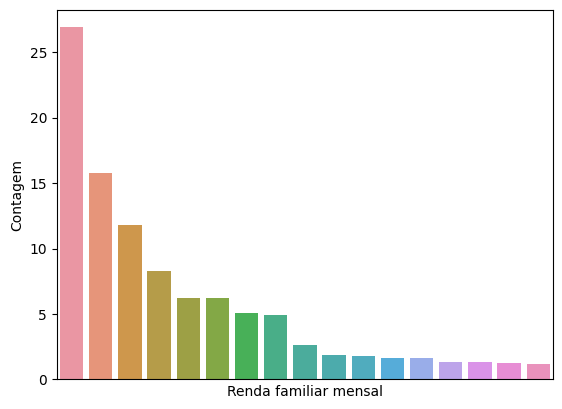

In [53]:
aux = enemx.loc[(enemx['TP_PRESENCA_CN'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_CH'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_LC'] == 'Presente na prova') &
                (enemx['TP_PRESENCA_MT'] == 'Presente na prova'), ['Q006']]
renda_presenca = aux['Q006'].value_counts()/aux['Q006'].count()*100
print(renda_presenca)
sns.barplot(x=renda_presenca.index, y=renda_presenca)
plt.xlabel('Renda familiar mensal')
plt.xticks([])
plt.ylabel("Contagem")
plt.show()

In [40]:
renda - renda_presenca

Q006
Acima de R$ 24.240,00.              -0.234885
Até R$ 1.212,00                      2.537040
De R$ 1.212,01 até R$ 1.818,00.      1.041591
De R$ 1.818,01 até R$ 2.424,00.      0.112635
De R$ 10.908,01 até R$ 12.120,00.   -0.279930
De R$ 12.120,01 até R$ 14.544,00.   -0.207875
De R$ 14.544,01 até R$ 18.180,00.   -0.234364
De R$ 18.180,01 até R$ 24.240,00.   -0.212231
De R$ 2.424,01 até R$ 3.030,00.     -0.335847
De R$ 3.030,01 até R$ 3.636,00.     -0.365144
De R$ 3.636,01 até R$ 4.848,00.     -0.628329
De R$ 4.848,01 até R$ 6.060,00.     -0.790811
De R$ 6.060,01 até R$ 7.272,00.     -0.388551
De R$ 7.272,01 até R$ 8.484,00.     -0.299608
De R$ 8.484,01 até R$ 9.696,00.     -0.219308
De R$ 9.696,01 até R$ 10.908,00.    -0.290244
Nenhuma Renda                        0.795863
Name: count, dtype: float64

Aqui observamos uma menor concentração de grupos que possuem renda mais alta se inscrevendo na prova, provavelmente por constituirem uma menor parcela da população. Além disso, observamos, nas parcelas com menor renda familiar, uma maior evasão, de modo que essas frequentam menos as provas

SG_UF_PROVA
SP    15.662415
MG     8.911727
BA     7.628251
RJ     7.217561
CE     6.512375
PA     5.828967
PE     5.454237
RS     4.381197
PR     4.326567
GO     4.074158
MA     3.823705
PB     2.969933
RN     2.532979
PI     2.428005
SC     2.381717
AM     2.329792
DF     1.881445
AL     1.839559
ES     1.832511
MT     1.708263
SE     1.677510
MS     1.285433
RO     0.919679
TO     0.846925
AP     0.652282
AC     0.650182
RR     0.242628
Name: count, dtype: float64


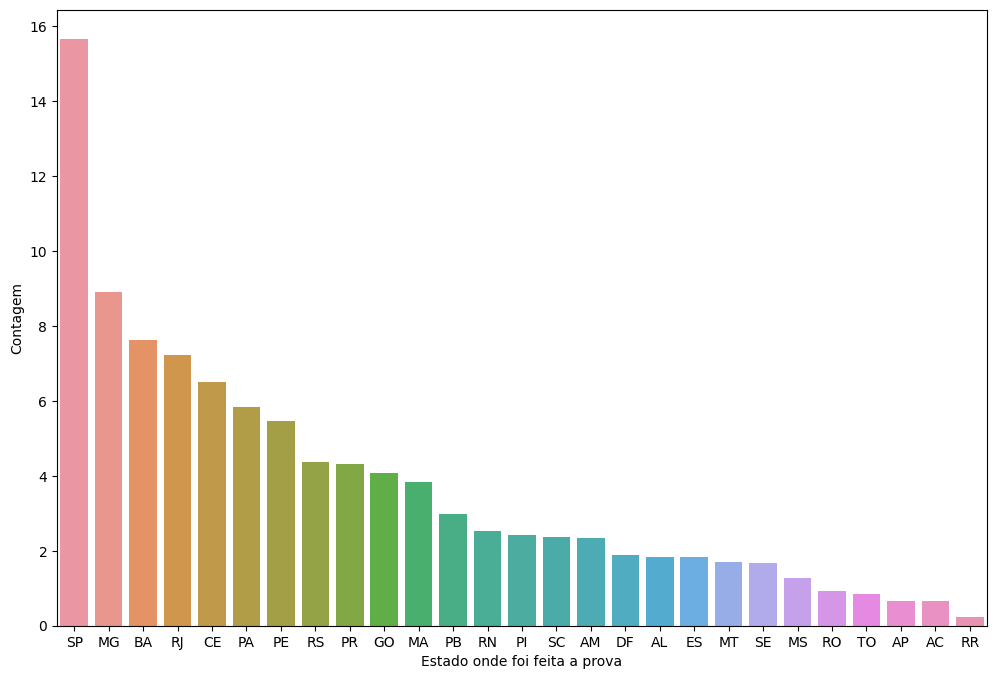

In [56]:
uf = enemx['SG_UF_PROVA'].value_counts()/enemx['SG_UF_PROVA'].count()*100
print(uf)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
sns.barplot(x=uf.index, y=uf)
plt.xlabel('Estado onde foi feita a prova')
plt.ylabel("Contagem")
plt.show()

Acima, temos uma distribuição dos inscritos por estado. Como são muitos estados, não vale a pena analisarmos em relação a frequência de provas, já que essa seria uma análise à parte.

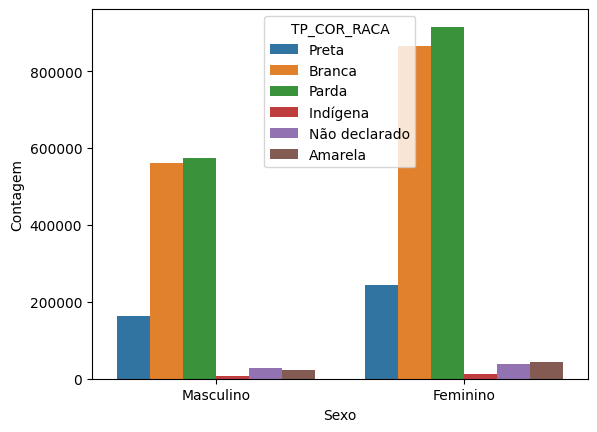

In [124]:
sns.countplot(x='TP_SEXO', hue='TP_COR_RACA', dodge=True, data=enemx)
plt.xlabel('Sexo')
plt.ylabel("Contagem")
plt.show()

Aqui temos uma análise cruzada das variáveis de `Sexo` com `Cor/Raça`. Pelo gráfico, podemos ver que a distribuição de cor/raça é similar entre os diferentes sexos.

Criamos uma coluna com a soma das notas, para que seja possível cruzar esse dados com os diferentes estados

In [84]:
enemx['Nota Total'] = enemx['NU_NOTA_CN'] + enemx['NU_NOTA_CH'] \
                    + enemx['NU_NOTA_LC'] + enemx['NU_NOTA_MT'] \
                    + enemx['NU_NOTA_REDACAO']
enemx['Nota Total']

0             NaN
1             NaN
2          2791.2
3          1973.1
4             NaN
            ...  
3476100       NaN
3476101       NaN
3476102    3035.3
3476103       NaN
3476104       NaN
Name: Nota Total, Length: 3476105, dtype: float64

SG_UF_PROVA
MG    2835.078249
SP    2828.368322
SC    2807.587885
DF    2802.651395
RJ    2790.473693
ES    2784.073399
RS    2780.175557
PR    2766.123288
GO    2700.770025
RN    2700.521462
MS    2679.506618
PE    2676.769182
PB    2670.056939
SE    2664.273378
BA    2647.440980
MT    2645.310228
RR    2642.684540
CE    2642.661684
AL    2642.273575
PI    2623.912777
TO    2615.857701
RO    2603.988802
AC    2583.725637
PA    2569.556735
MA    2559.032694
AP    2552.015079
AM    2516.863092
Name: Nota Total, dtype: float64


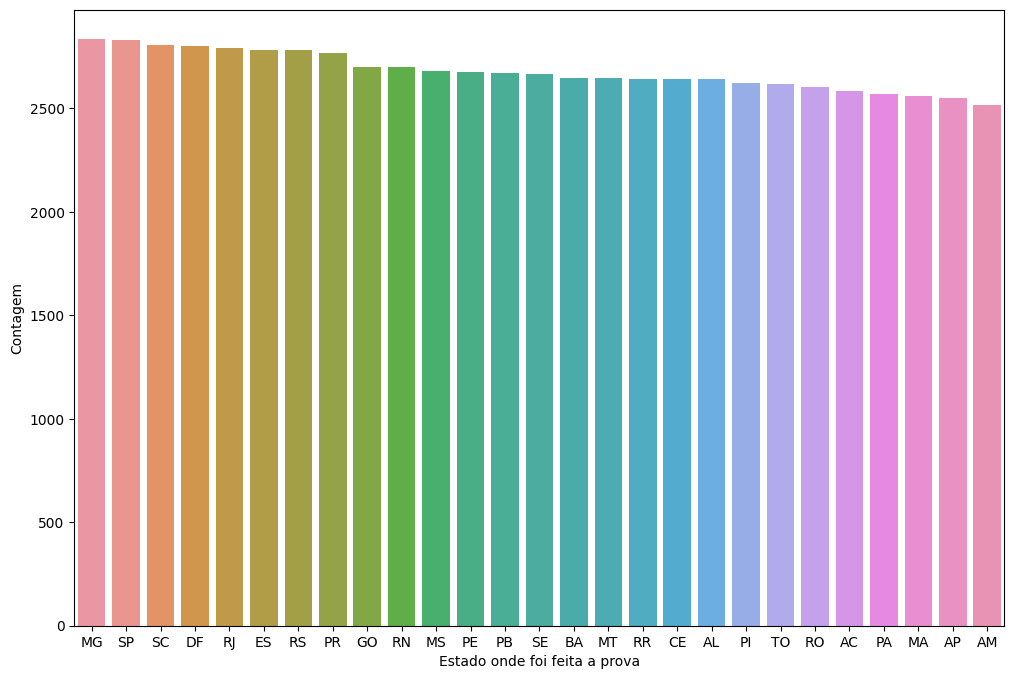

In [74]:
uf_group = enemx[['Nota Total', 'SG_UF_PROVA']].groupby(by='SG_UF_PROVA').mean()['Nota Total']
uf_group = uf_group.sort_values(ascending=False)
print(uf_group)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
sns.barplot(x=uf_group.index, y=uf_group)
plt.xlabel('Estado onde foi feita a prova')
plt.ylabel("Contagem")
plt.show()

Nessa última comparação, tivemos uma ordenação da soma das notas (em todas as modalidades) para os diferentes estados do conjunto de dados.

Várias outras análises são possíveis utilizando outras váriaveis categóricas, cruzando diferentes variáveis como feito anteriormente, ou até mesmo outras abordagens. Mas agora seguimos com outras análises.

#### Análise das distribuições

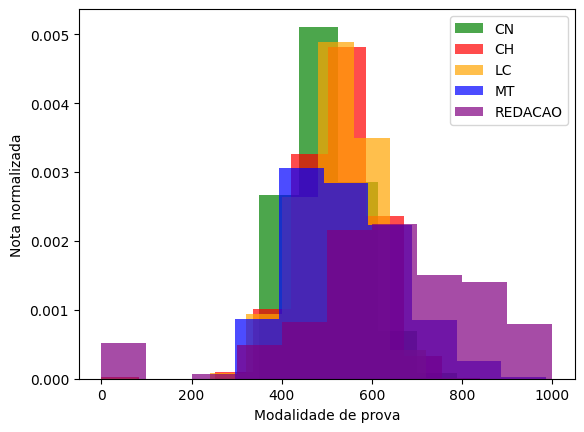

In [6]:
for name, color in zip(['CN', 'CH', 'LC', 'MT', 'REDACAO'], ['green', 'red', 'orange', 'blue', 'purple']):
    plt.hist(enemx['NU_NOTA_'+name], alpha=0.7, color=color, density=True, label=name)
plt.xlabel("Modalidade de prova")
plt.ylabel('Nota normalizada')
plt.legend(loc='upper right')
plt.show()

Modalidade CN - mu = 495.93052035858074 / std = 72.00973657050085
Modalidade CH - mu = 526.9531490606155 / std = 81.48444678610701


/tmp/ipykernel_29640/1607964211.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color=color, label=name)


Modalidade LC - mu = 517.4389348940138 / std = 77.55489899947169
Modalidade MT - mu = 542.5032163182819 / std = 116.02248905389938
Modalidade REDACAO - mu = 618.4796999489059 / std = 212.2124367938697


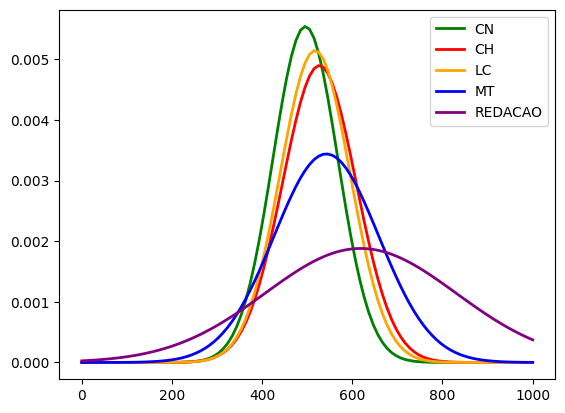

In [8]:
for name, color in zip(['CN', 'CH', 'LC', 'MT', 'REDACAO'], ['green', 'red', 'orange', 'blue', 'purple']):
    mu, std = stats.norm.fit(enemx.loc[~enemx['NU_NOTA_'+name].isnull(), 'NU_NOTA_'+name])
    print(f'Modalidade {name} - mu = {mu} / std = {std}')
    x = np.linspace(0, 1_000, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, color=color, label=name)
plt.legend(loc='upper right')
plt.show()

Aqui, temos imagens tanto de discretizações das variáveis de notas, quanto as normais que receberam um fit a partir dos dados originais de notas para cada uma das modalidades

A abordagem interessante aqui é que, como pede o enunciado do projeto, já tínhamos trabalhado com a definição de tipos (salvando e transformando os `dtypes`); tratamos dados ausentes (quando vimos o número de dados ausentes e quando utilizamos o método `count`, para considerar, na nossa análise coluna à coluna, o número de instâncias preenchidas); e fizemos limpezas e transformações diversas na seção anterior. Mas, agora, tanto discretizamos os dados de notas, que são númericos, para fazer histogramas; quanto os normalizamos e buscamos adequar distribuições normais às suas distribuições originais, percorrendo de forma ampla os tópicos do item 2 do Projeto 1.

In [3]:
enemx.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,2.355395e+06,2.493442e+06,2.493442e+06,2.355395e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06
mean,4.959305e+02,5.269531e+02,5.174389e+02,5.425032e+02,1.193923e+02,1.409609e+02,1.148686e+02,1.294384e+02,1.138195e+02,6.184797e+02
std,7.200975e+01,8.148446e+01,7.755491e+01,1.160225e+02,3.700626e+01,5.353708e+01,4.102659e+01,4.268095e+01,5.982160e+01,2.122125e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.405000e+02,4.770000e+02,4.684000e+02,4.490000e+02,1.000000e+02,1.200000e+02,1.000000e+02,1.200000e+02,8.000000e+01,5.200000e+02
50%,4.856000e+02,5.299000e+02,5.255000e+02,5.308000e+02,1.200000e+02,1.400000e+02,1.200000e+02,1.200000e+02,1.200000e+02,6.200000e+02
75%,5.433000e+02,5.819000e+02,5.732000e+02,6.224000e+02,1.400000e+02,2.000000e+02,1.400000e+02,1.600000e+02,1.600000e+02,7.600000e+02
max,8.753000e+02,8.392000e+02,8.010000e+02,9.857000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,1.000000e+03


Nas estatísticas descritivas, vemos somente estatísticas referentes às notas das modalides e redação (`COMPX`refer-se à nota da redação para uma determinada compotência). Além disso, podemos ver que as normalizações feitas anteriormente coincidem com as estatísticas descritivas de `média` e `desvio padrão` das nossas distribuições, como era de se esperar.

Podem levar essa análise um pouco adianta ao observarmos os `quartis`, que também assemelham-se àqueles observados nos histogramas anteriores. Isso fica ainda mais fácil de ver quando as distribuições assemelham-se mais ao comportamento de uma normal.

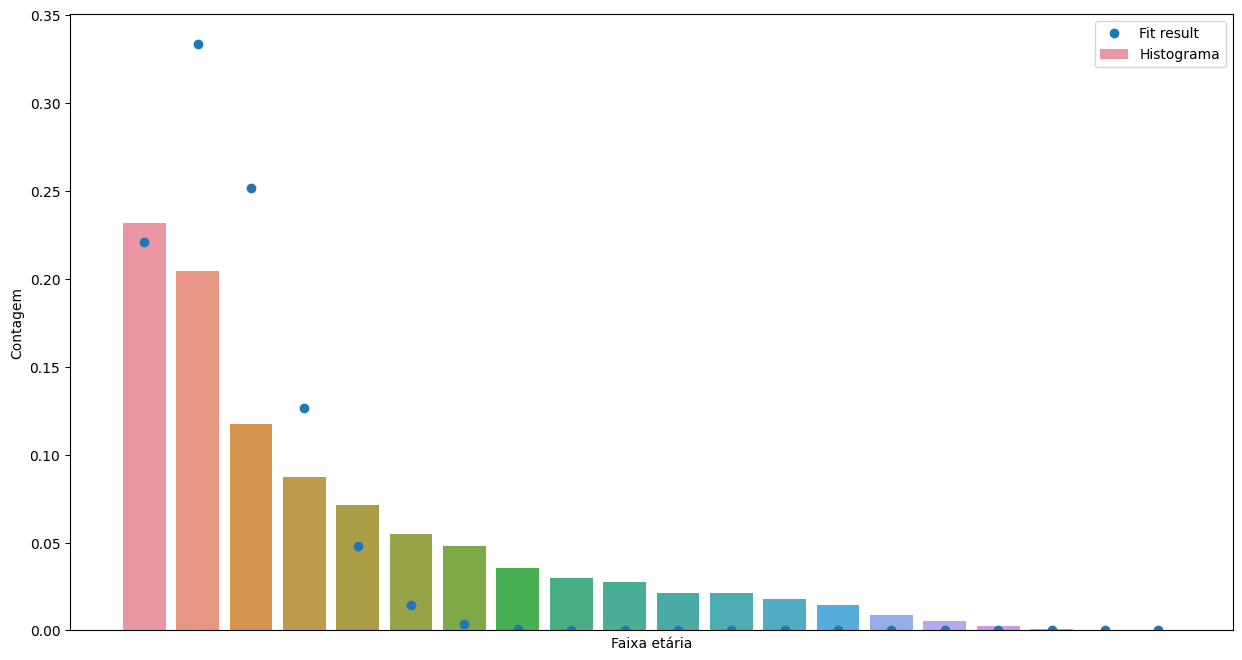

In [44]:
idade = enemx['TP_FAIXA_ETARIA'].value_counts()/enemx['TP_FAIXA_ETARIA'].count()
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)
sns.barplot(x=idade.index, y=idade, label='Histograma')

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return stats.poisson.pmf(k, lamb)

# fit with curve_fit
x = np.arange(0, 20)
parameters, cov_matrix = curve_fit(fit_function, x, idade)

# plot poisson-deviation with fitted parameter
plt.plot(x, fit_function(x, *parameters), marker='o', linestyle='', label='Fit result',)

plt.xlabel('Faixa etária')
plt.xticks([])
plt.ylabel("Contagem")
plt.legend()
plt.show()

Aqui, podemos ver que o comportamento de decaimento da nossa distribuição, apesar de interessante, não pode ser aproximado de forma interessante para uma poisson.

Isso é característico do próprio processo de tentar encontrar uma distribuição que se adeque aos dados, o que geralmente é difícil e precisa de análises diversas, conhecimento específico do domínio, entre outras técnincas.

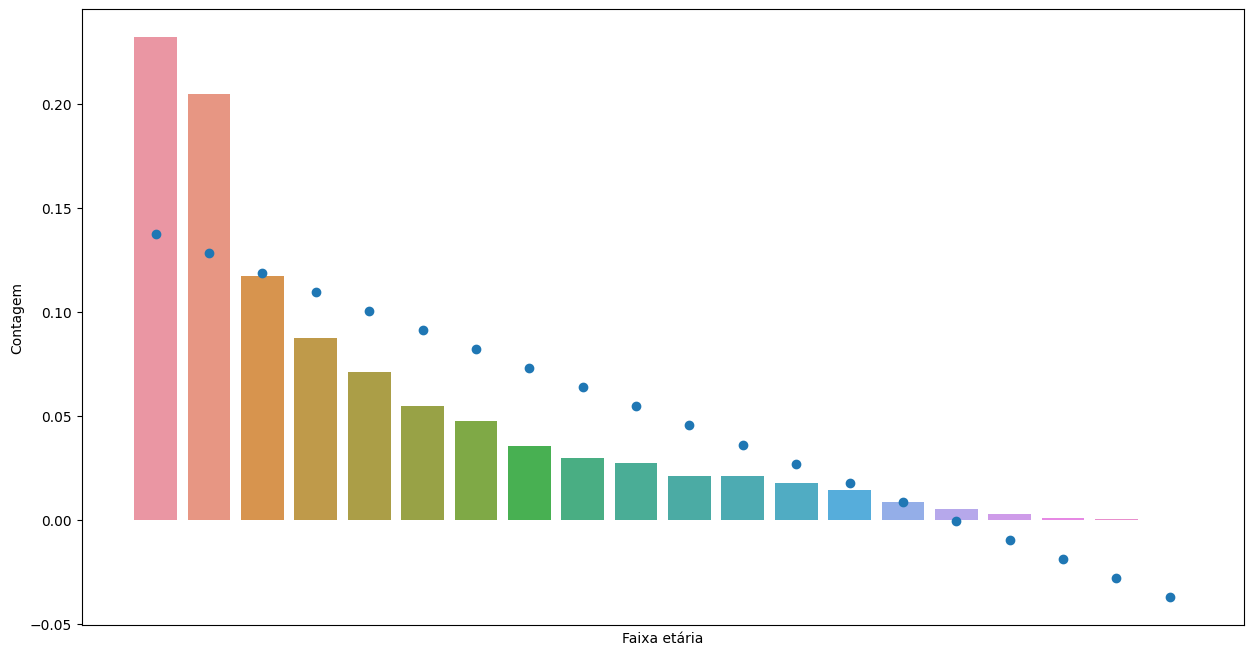

In [47]:
idade = enemx['TP_FAIXA_ETARIA'].value_counts()/enemx['TP_FAIXA_ETARIA'].count()
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)
sns.barplot(x=idade.index, y=idade, label='Histograma')

def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

# fit with curve_fit
x = np.arange(0, 20)
parameters, cov_matrix = curve_fit(model_func, x, idade, maxfev = 1_000)

# plot poisson-deviation with fitted parameter
plt.plot(x, model_func(x, *parameters), marker='o', linestyle='', label='Fit result',)

plt.xlabel('Faixa etária')
plt.xticks([])
plt.ylabel("Contagem")
plt.show()

Mesmo com um comportamento que lembra um decaimento exponencial, a biblioteca `scipy` não conseguiu aproximar suficientemente bem a curva das idades.

In [52]:
enemx['TP_FAIXA_ETARIA']

0          Entre 41 e 45 anos
1          Entre 41 e 45 anos
2                     20 anos
3                     21 anos
4                     19 anos
                  ...        
3476100               18 anos
3476101    Entre 41 e 45 anos
3476102               17 anos
3476103               18 anos
3476104               17 anos
Name: TP_FAIXA_ETARIA, Length: 3476105, dtype: object

### Análise Estatística

Aqui apresentamos estatísticas descritivas dos dados (como já foi feito anteriormente), em conjunto de visualizações e realização de testes

In [9]:
enemx.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,2.355395e+06,2.493442e+06,2.493442e+06,2.355395e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06,2.493442e+06
mean,4.959305e+02,5.269531e+02,5.174389e+02,5.425032e+02,1.193923e+02,1.409609e+02,1.148686e+02,1.294384e+02,1.138195e+02,6.184797e+02
std,7.200975e+01,8.148446e+01,7.755491e+01,1.160225e+02,3.700626e+01,5.353708e+01,4.102659e+01,4.268095e+01,5.982160e+01,2.122125e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.405000e+02,4.770000e+02,4.684000e+02,4.490000e+02,1.000000e+02,1.200000e+02,1.000000e+02,1.200000e+02,8.000000e+01,5.200000e+02
50%,4.856000e+02,5.299000e+02,5.255000e+02,5.308000e+02,1.200000e+02,1.400000e+02,1.200000e+02,1.200000e+02,1.200000e+02,6.200000e+02
75%,5.433000e+02,5.819000e+02,5.732000e+02,6.224000e+02,1.400000e+02,2.000000e+02,1.400000e+02,1.600000e+02,1.600000e+02,7.600000e+02
max,8.753000e+02,8.392000e+02,8.010000e+02,9.857000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,1.000000e+03


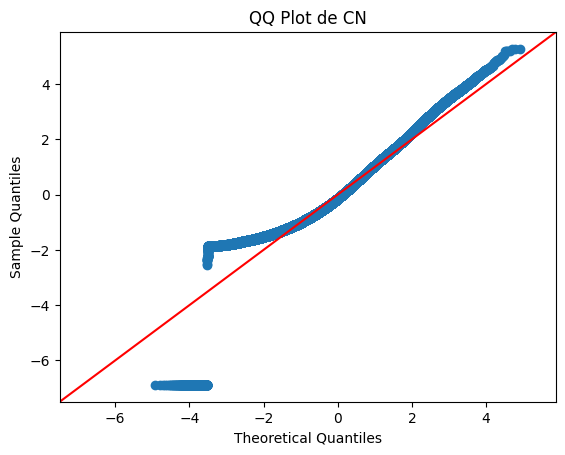

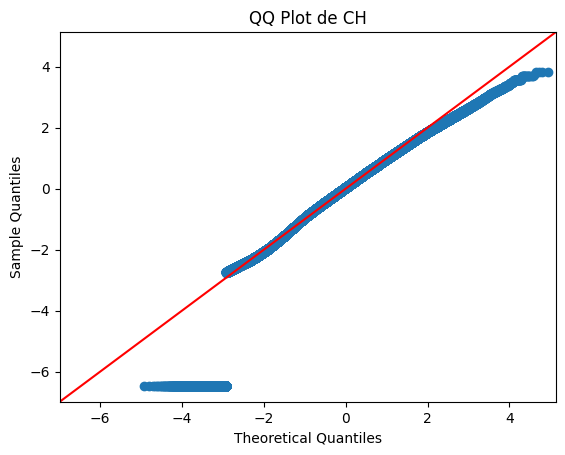

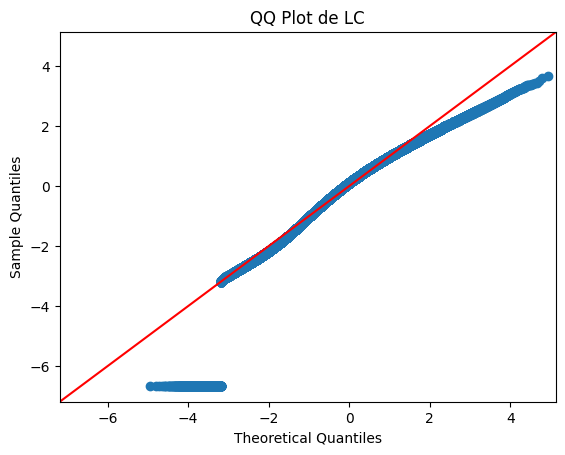

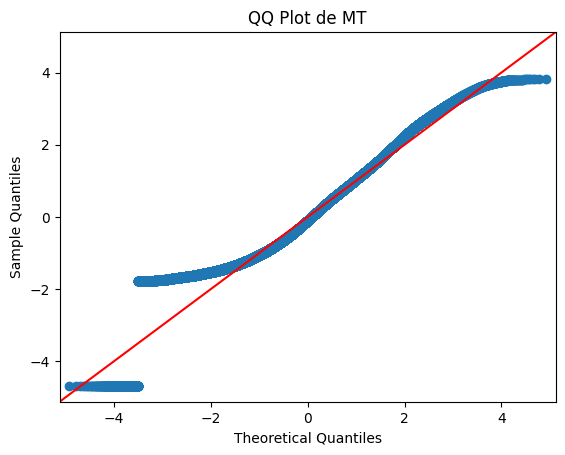

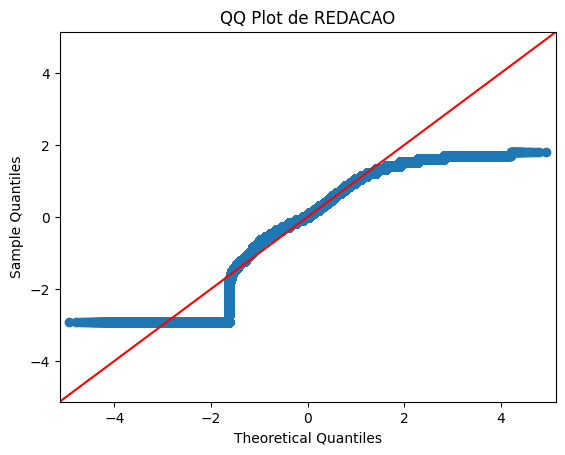

In [44]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    aux = enemx.loc[~enemx['NU_NOTA_'+name].isnull(), 'NU_NOTA_'+name].to_numpy()
    normalized = (aux-np.mean(aux))/np.std(aux)
    sm.qqplot(normalized, line='45', label=name)
    plt.title(f'QQ Plot de {name}')
    plt.show()

Realizamos QQ plots porque algumas das distribuições das notas modalidades lembravam bastante distribuições normais quando realizamos a análise dos histogramas e apromixação por normais (e comparando com as estatísticas descritivas).

Agora, vemos que algumas realmente possuem resultados parecidos com os quantiles teóricos, poŕem vemos um comportamento um pouco estranho nas partes mais à esquerda dos gráficos. Esse comportamento deriva das notas zeradas, que, no Enem, nunca tomam valor zero. Observe o que acontece quando retiramos essas notas

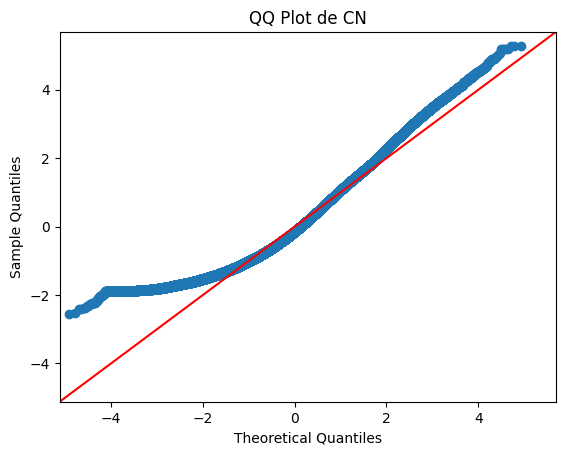

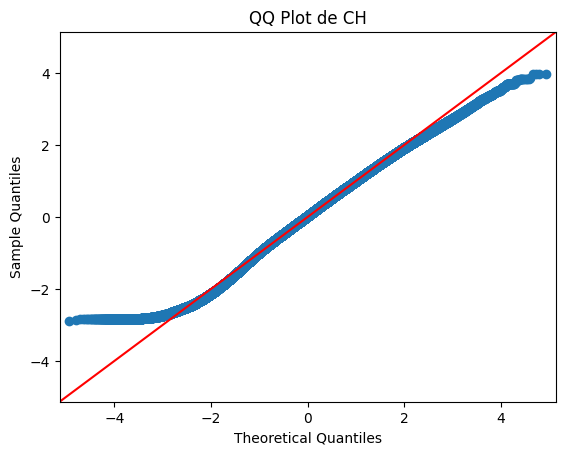

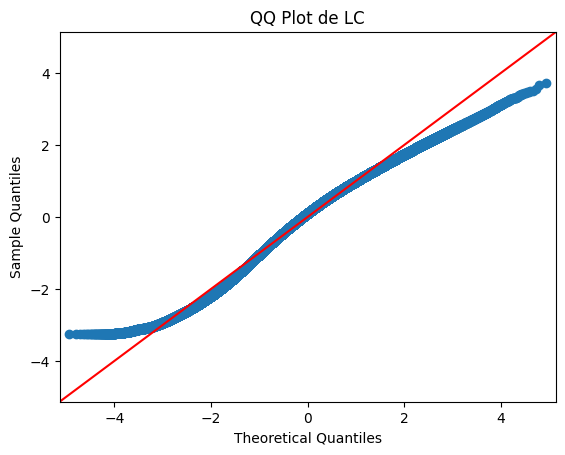

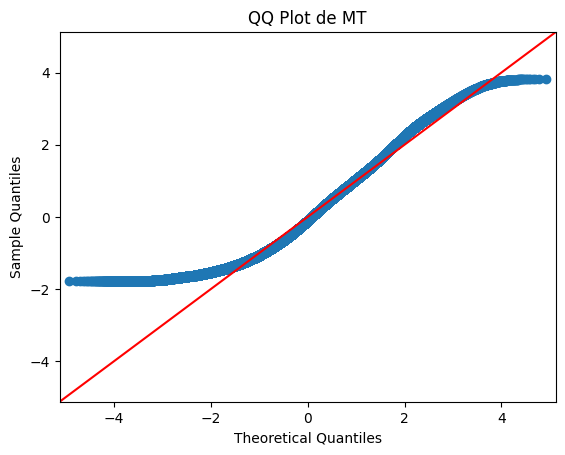

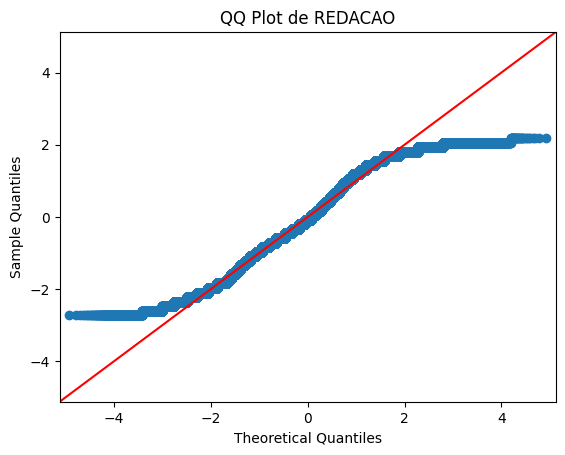

In [45]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    aux = enemx.loc[enemx['NU_NOTA_'+name] > 200, 'NU_NOTA_'+name].to_numpy()
    normalized = (aux-np.mean(aux))/np.std(aux)
    sm.qqplot(normalized, line='45', label=name)
    plt.title(f'QQ Plot de {name}')
    plt.show()

Ao selecionarmos somente notas não zeradas, aquelas acima de 200, observamos um comportamento mais similar aos quantiles teóricos por parte de todos os gráficos. Seguindo essa análise, realizamos um teste de Shapiro-Wilk

In [49]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    aux = enemx.loc[~enemx['NU_NOTA_'+name].isnull(), 'NU_NOTA_'+name].sample(5_000).to_numpy()
    print(f'Shapiro-Wilk de {name} = {stats.shapiro(aux)}')

Shapiro-Wilk de CN = ShapiroResult(statistic=0.9642055034637451, pvalue=1.7121055015917463e-33)
Shapiro-Wilk de CH = ShapiroResult(statistic=0.9710359573364258, pvalue=1.2104020191434023e-30)
Shapiro-Wilk de LC = ShapiroResult(statistic=0.9772700667381287, pvalue=1.5179298708710636e-27)
Shapiro-Wilk de MT = ShapiroResult(statistic=0.9713438749313354, pvalue=1.6719759567564927e-30)
Shapiro-Wilk de REDACAO = ShapiroResult(statistic=0.9116873145103455, pvalue=0.0)


In [50]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    aux = enemx.loc[enemx['NU_NOTA_'+name] > 200, 'NU_NOTA_'+name].sample(5_000).to_numpy()
    print(f'Shapiro-Wilk de {name} = {stats.shapiro(aux)}')

Shapiro-Wilk de CN = ShapiroResult(statistic=0.9686250686645508, pvalue=1.0534434776730199e-31)
Shapiro-Wilk de CH = ShapiroResult(statistic=0.9979724884033203, pvalue=3.911576641257852e-06)
Shapiro-Wilk de LC = ShapiroResult(statistic=0.9888049960136414, pvalue=1.7256122366259003e-19)
Shapiro-Wilk de MT = ShapiroResult(statistic=0.9706996083259583, pvalue=8.530772212109527e-31)
Shapiro-Wilk de REDACAO = ShapiroResult(statistic=0.979979932308197, pvalue=5.426314705733232e-26)


Como comentamos anteriormente, observamos aqui p-valores bastante abaixo de `0.05`, o que poderia nos possibilitar a rejeição da hipótese nula por meio do teste Shapiro-Wilk. 

Logo, apenas a análise de evidências pelo QQplot induz a uma conclusão que pode não ser a mais correta. Pelos testes realizados, vemos que, mesmo retirando notas baixas, ainda não possuímos uma distribuição normal.

**Obs:** tivemos que fazer um `sample` de 5_000 amostras, porque esse é o máximo que a biblioteca consegue fazer antes de perder precisão numérica.

Agora, prosseguimos com a análise das distribuições por sexo e cor/raça, para verficarmos que não existe diferença estatisticamente signifitcante entre elas.

MannWhitneyU de CN = MannwhitneyuResult(statistic=10420900.5, pvalue=4.904422724256159e-47)


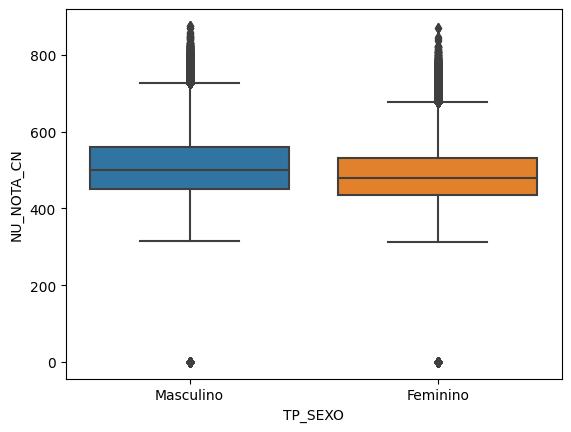

MannWhitneyU de CH = MannwhitneyuResult(statistic=11406323.5, pvalue=3.540955560400093e-14)


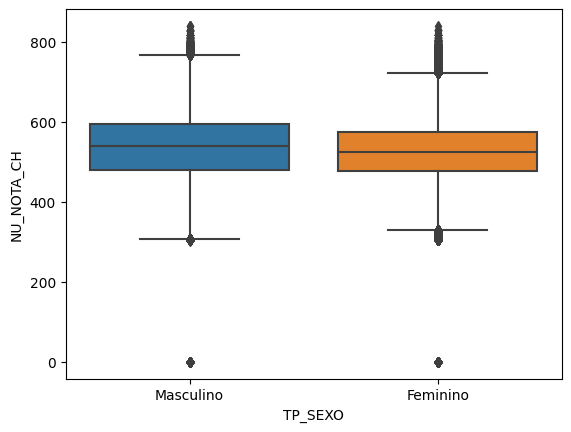

MannWhitneyU de LC = MannwhitneyuResult(statistic=12242519.0, pvalue=0.07445807301459036)


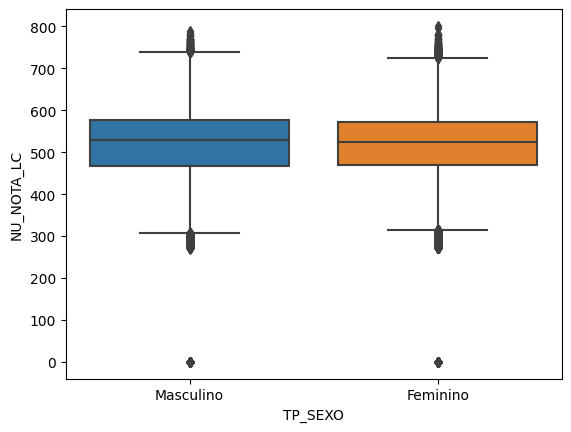

MannWhitneyU de MT = MannwhitneyuResult(statistic=10035009.0, pvalue=2.197645770375279e-65)


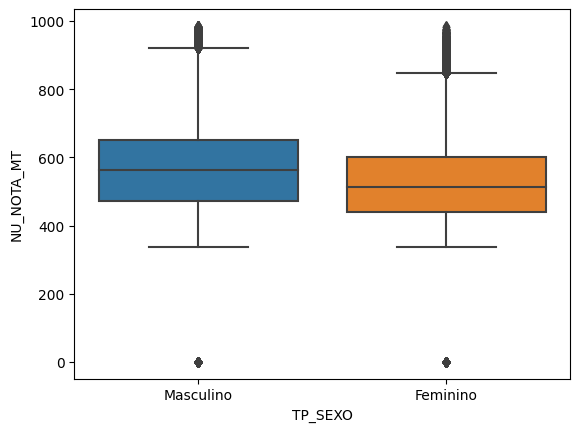

MannWhitneyU de REDACAO = MannwhitneyuResult(statistic=13646702.5, pvalue=1.8596449796821745e-15)


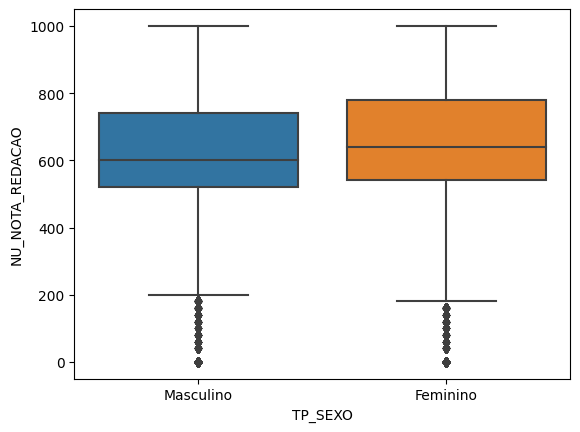

In [82]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    fem = enemx.loc[(enemx['TP_SEXO'] == 'Feminino') & (enemx['NU_NOTA_'+name] > 200) , 'NU_NOTA_'+name].sample(5_000)
    mas = enemx.loc[(enemx['TP_SEXO'] == 'Masculino') & (enemx['NU_NOTA_'+name] > 200) , 'NU_NOTA_'+name].sample(5_000)
    print(f"MannWhitneyU de {name} = {stats.mannwhitneyu(fem, mas, alternative='two-sided')}")
    sns.boxplot(data=enemx, x='TP_SEXO', y='NU_NOTA_'+name)
    plt.show()

Novamente, tivemos que fazer um  `sample` para não perder precisão numérica.

Note que, pelo teste U de Mann-Whitney, o único caso no qual não podemos dizer que temos distribuições estatísticamente diferentes seria na modalidade LC.

Kruskal-Wallis para CN = KruskalResult(statistic=122.1889535921506, pvalue=4.317115492062188e-17)


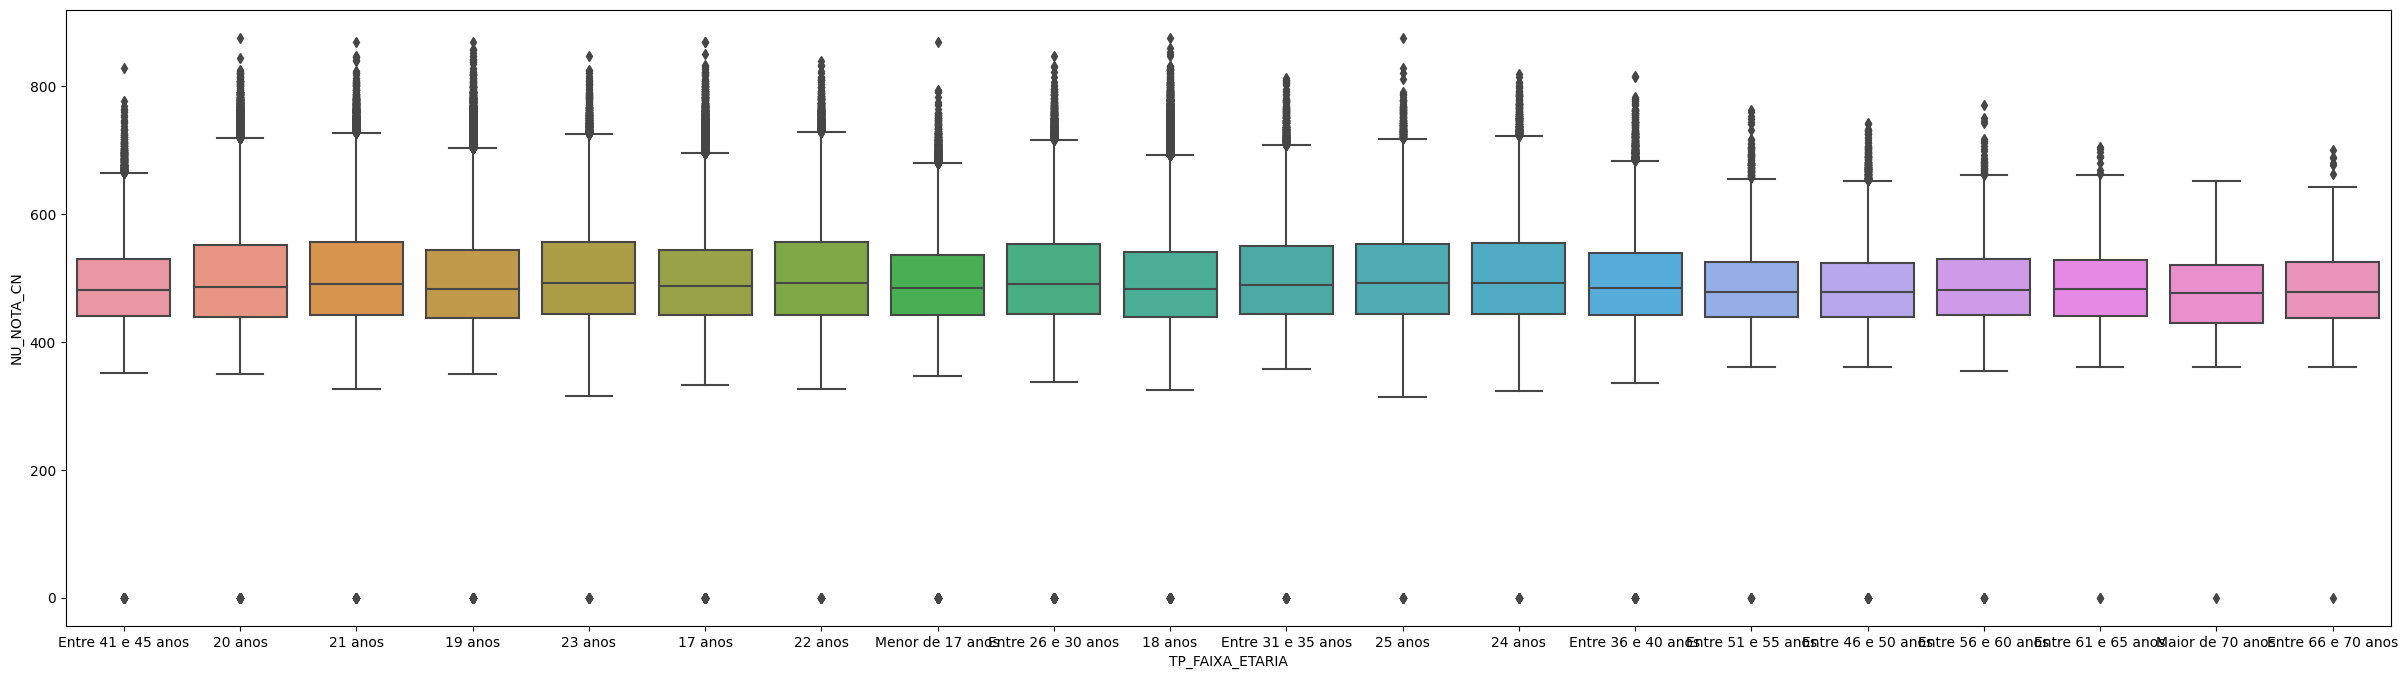

Kruskal-Wallis para CH = KruskalResult(statistic=82.62656387623899, pvalue=6.529442869414811e-10)


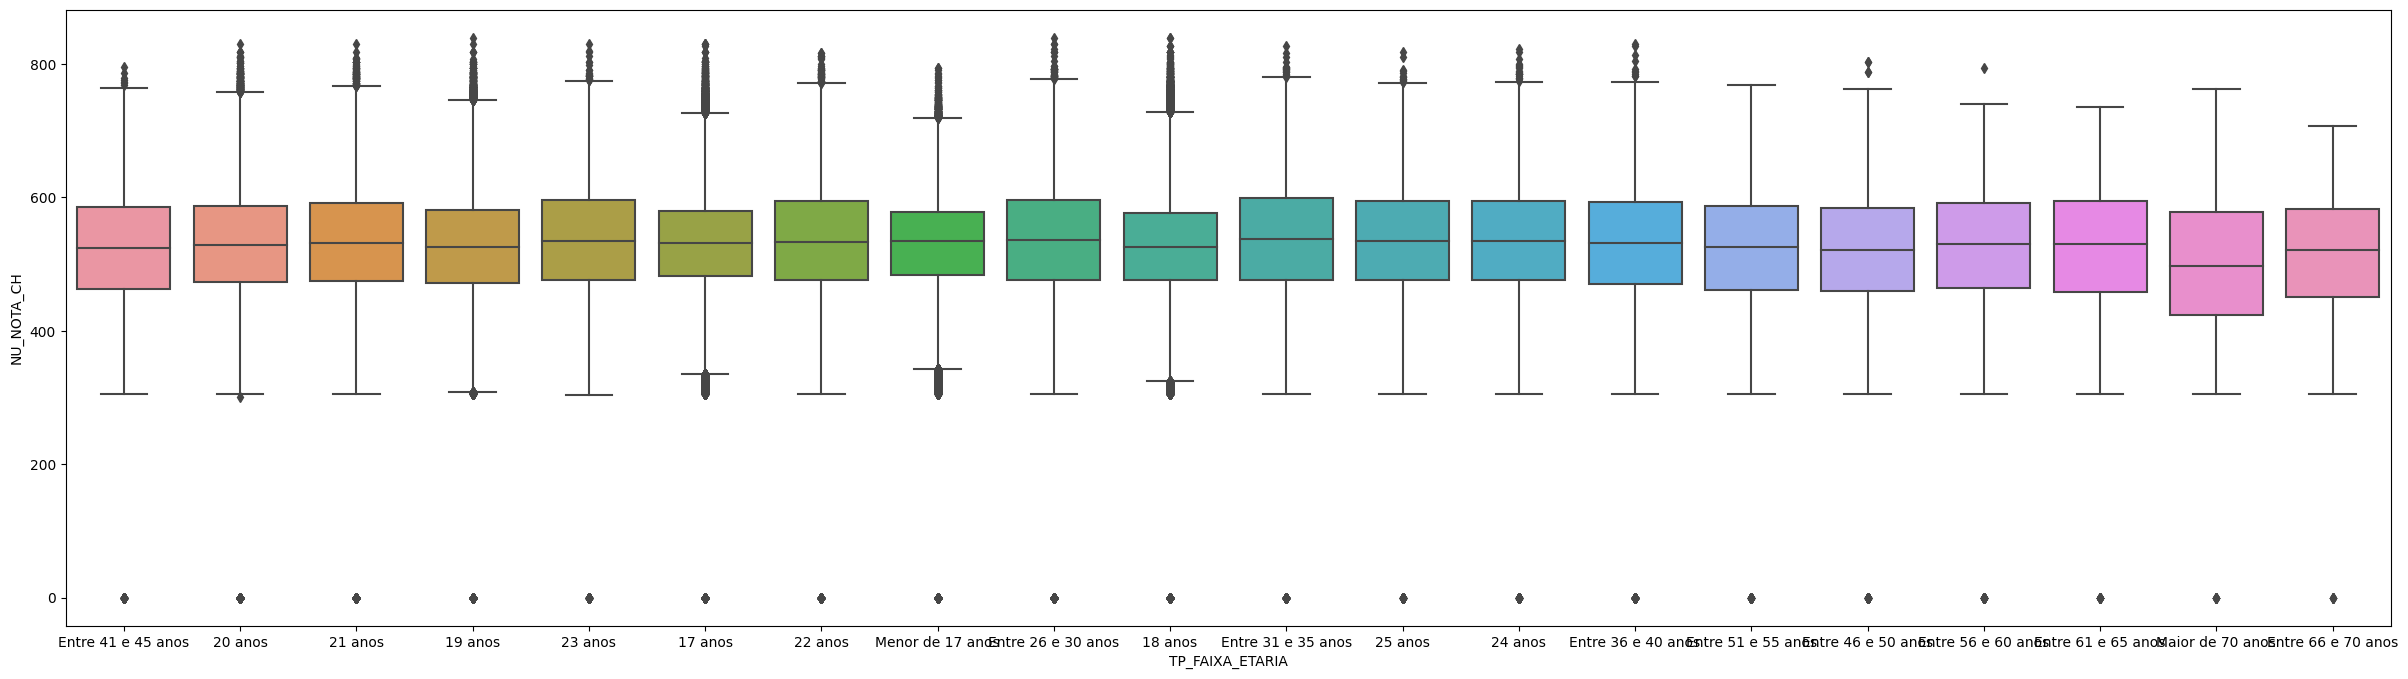

Kruskal-Wallis para LC = KruskalResult(statistic=773.2887088153352, pvalue=1.0177825903065936e-151)


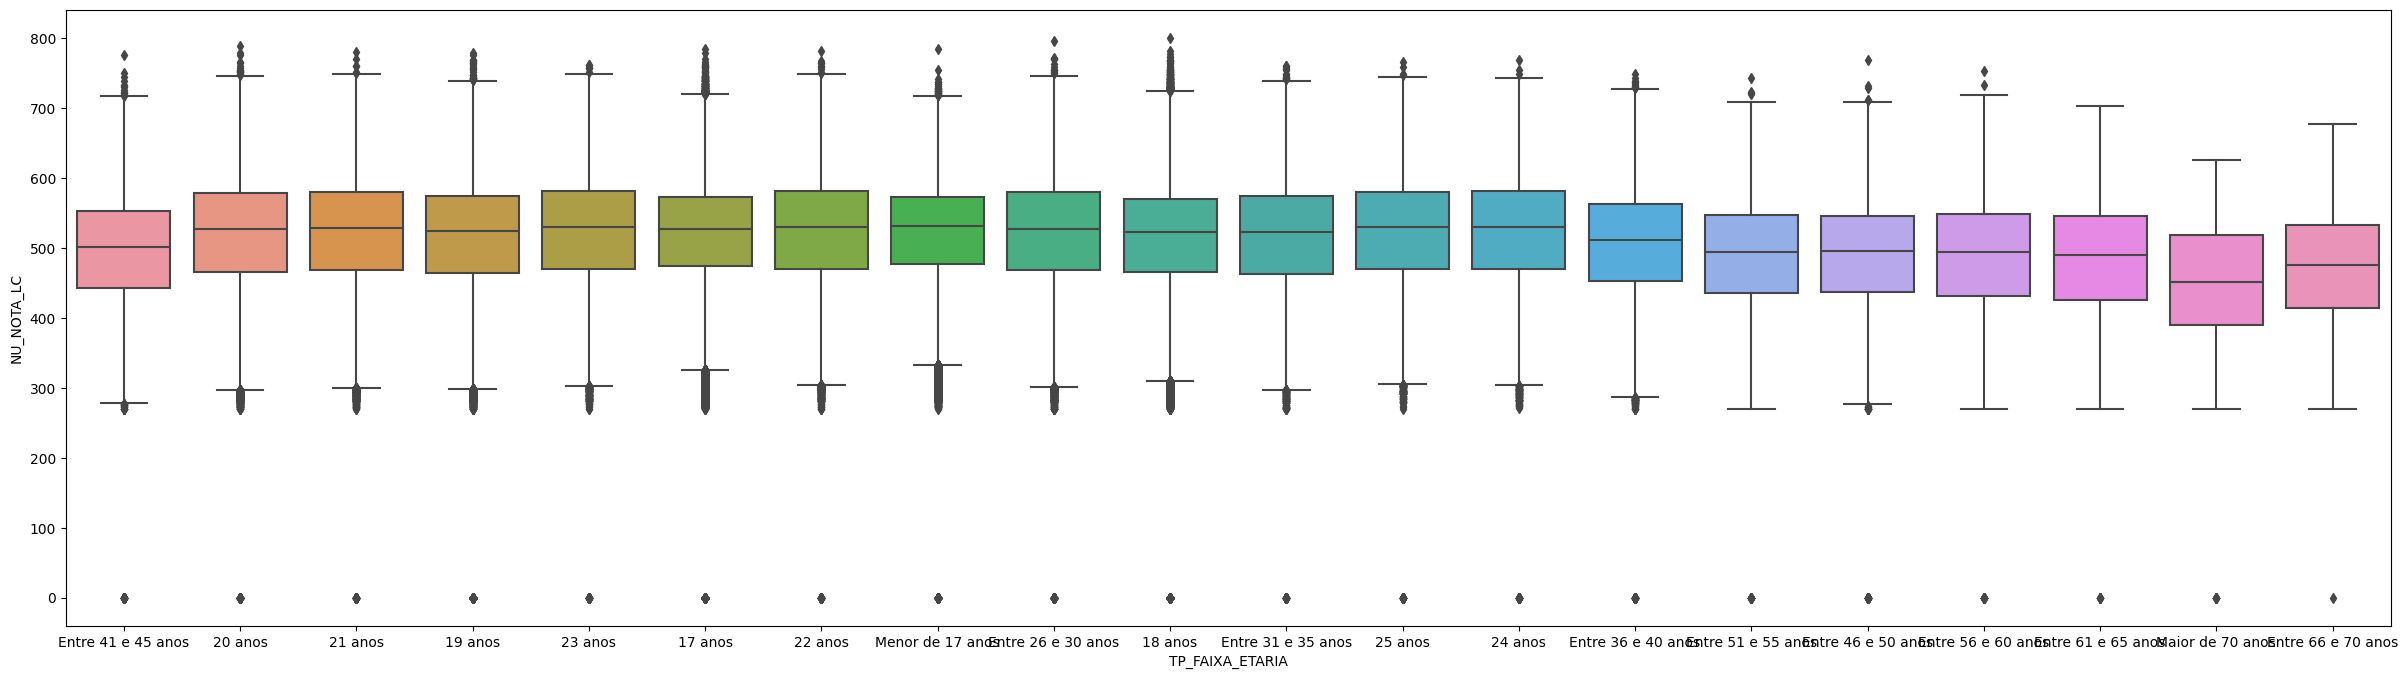

Kruskal-Wallis para MT = KruskalResult(statistic=646.8495814677589, pvalue=6.403061135708985e-125)


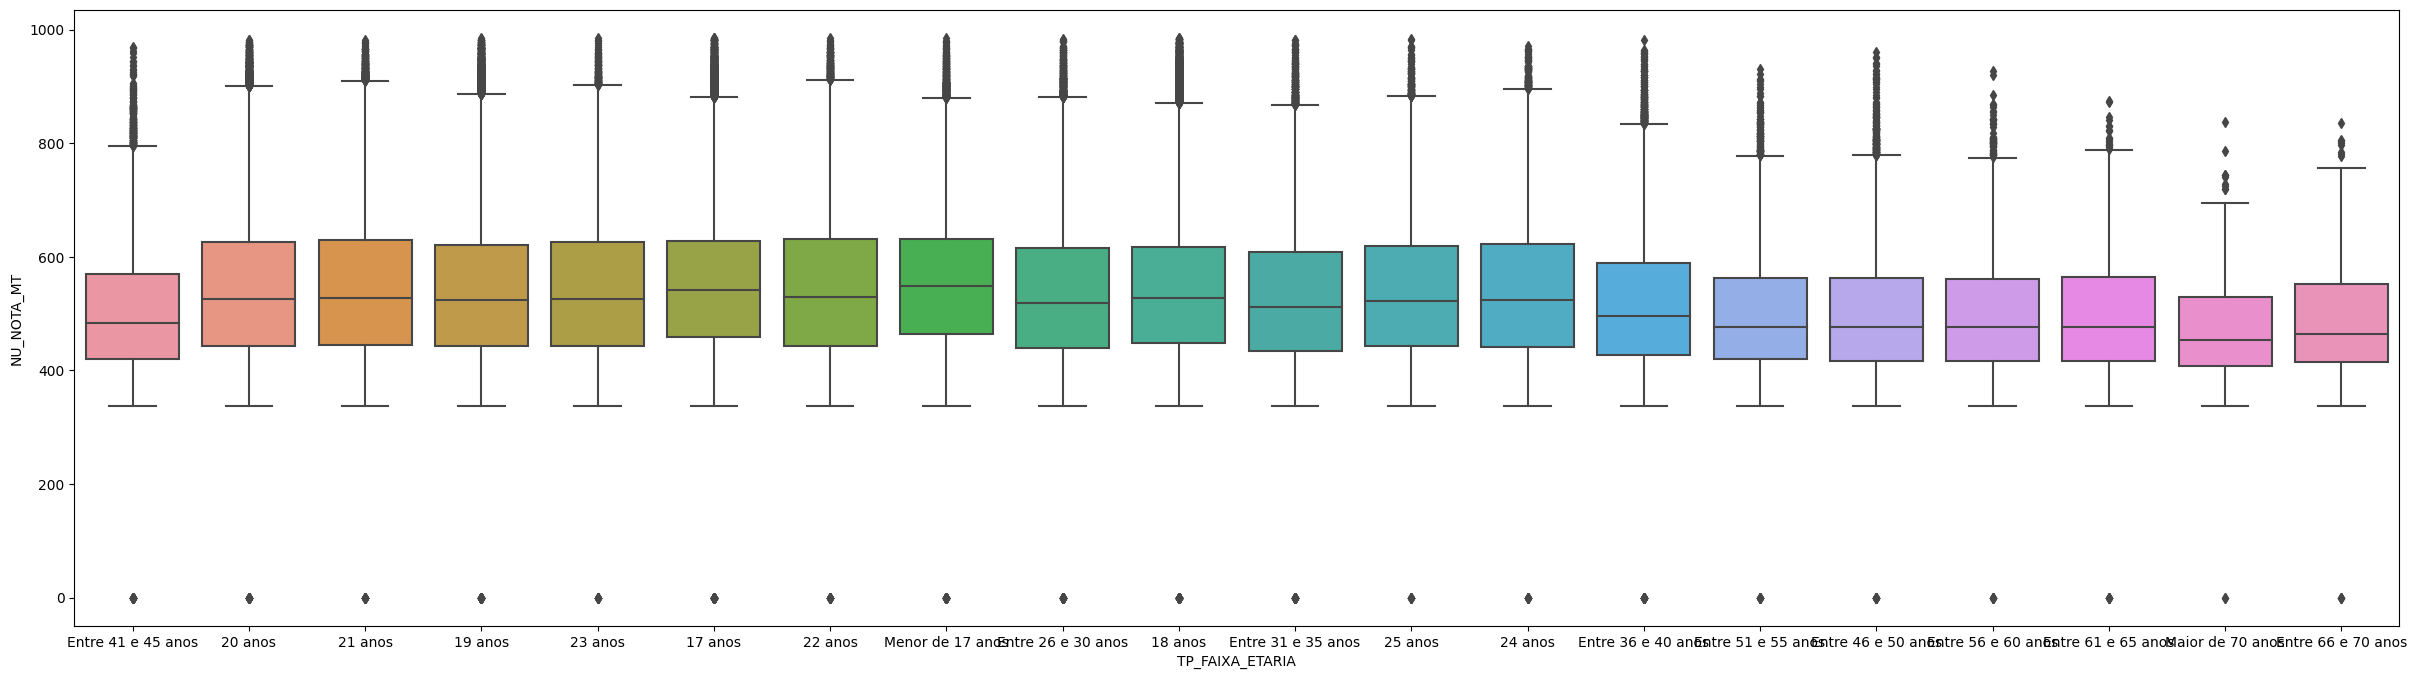

Kruskal-Wallis para REDACAO = KruskalResult(statistic=2771.268627908046, pvalue=0.0)


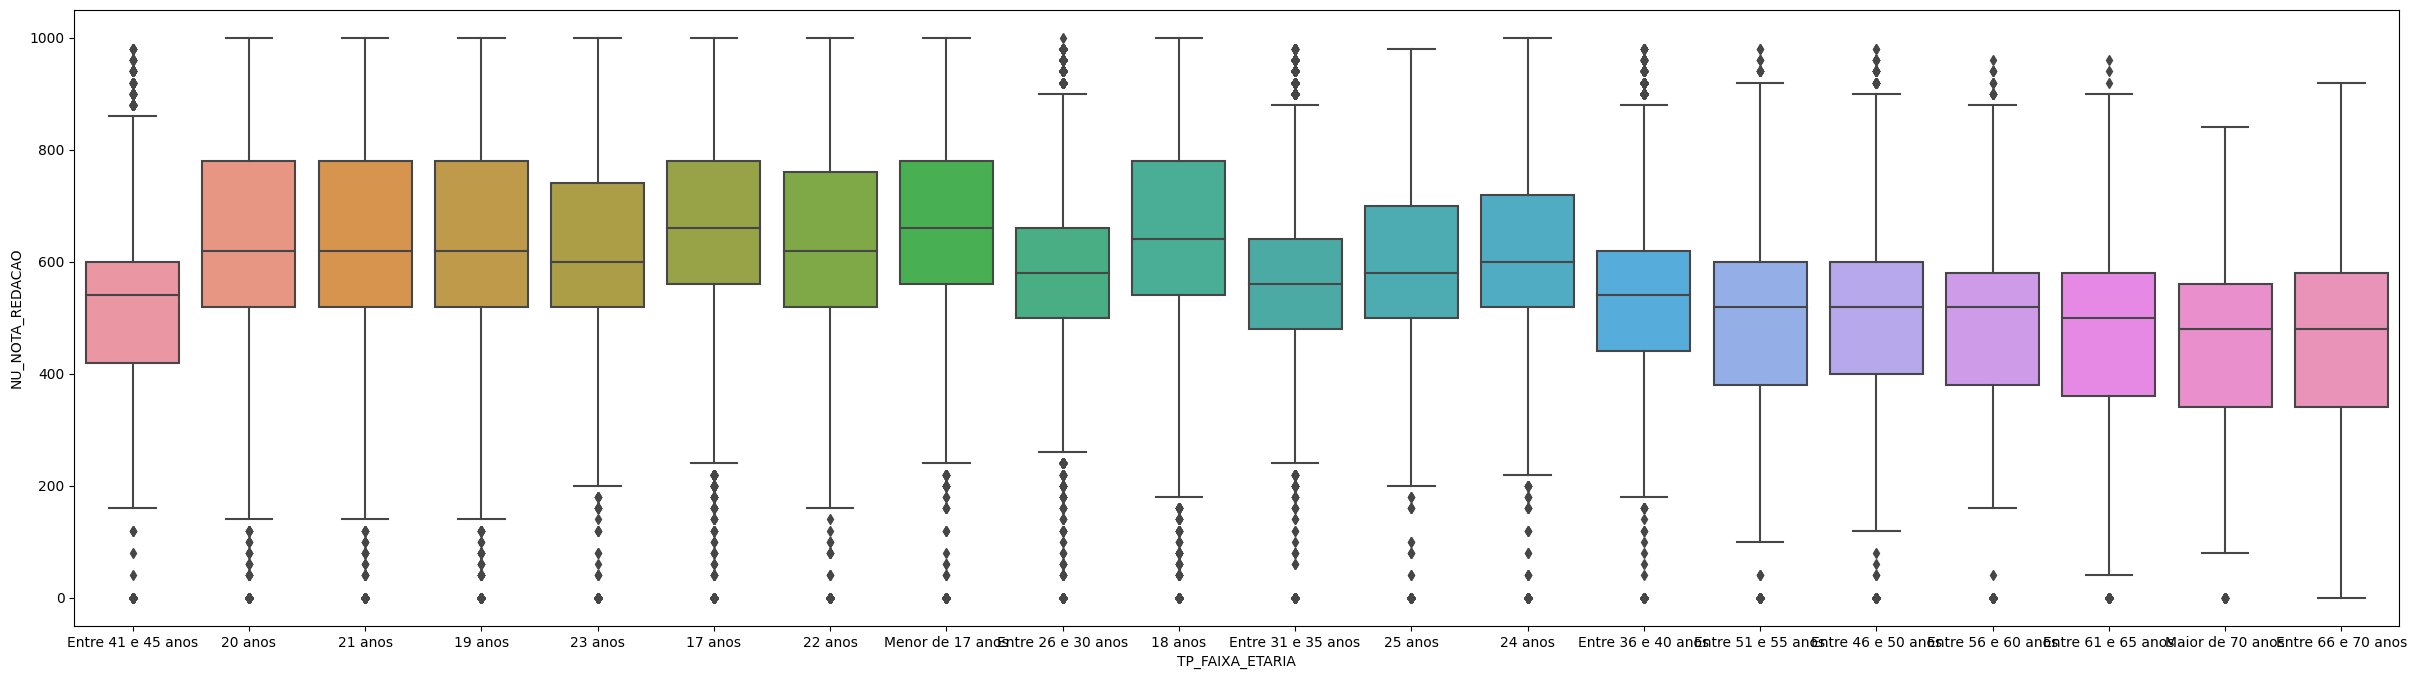

In [122]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    notas_idade = []
    for idade in enemx['TP_FAIXA_ETARIA'].unique():
        aux = enemx.loc[(enemx['TP_FAIXA_ETARIA'] == idade) & (enemx['NU_NOTA_' + name] > 200) , 'NU_NOTA_'+name]
        if aux.shape[0] > 1_000:
            aux = aux.sample(1_000)
        notas_idade.append(aux)
    print(f'Kruskal-Wallis para {name} = {stats.kruskal(*notas_idade)}')
    f = plt.figure()
    f.set_figwidth(30)
    f.set_figheight(8)
    sns.boxplot(data=enemx, x='TP_FAIXA_ETARIA', y='NU_NOTA_'+name)
    plt.show()

Kruskal-Wallis para CN = KruskalResult(statistic=714.4378332350003, pvalue=3.7100821322199144e-152)


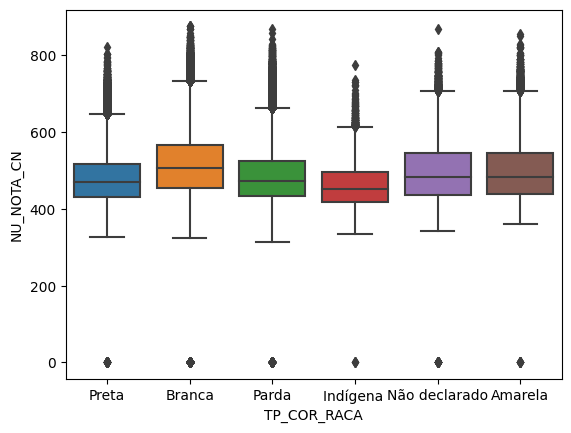

Kruskal-Wallis para CH = KruskalResult(statistic=793.7711317805928, pvalue=2.5750809835708697e-169)


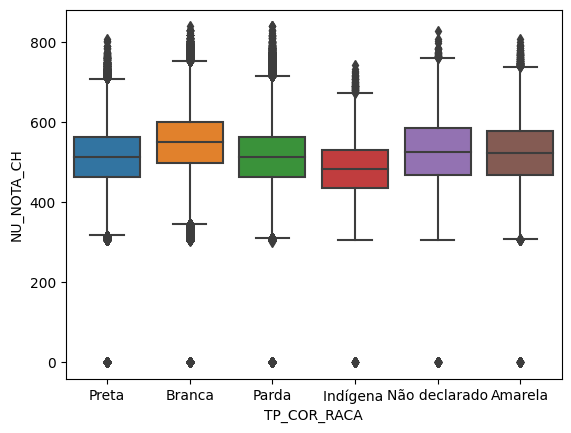

Kruskal-Wallis para LC = KruskalResult(statistic=1113.185688354307, pvalue=1.8648298758250976e-238)


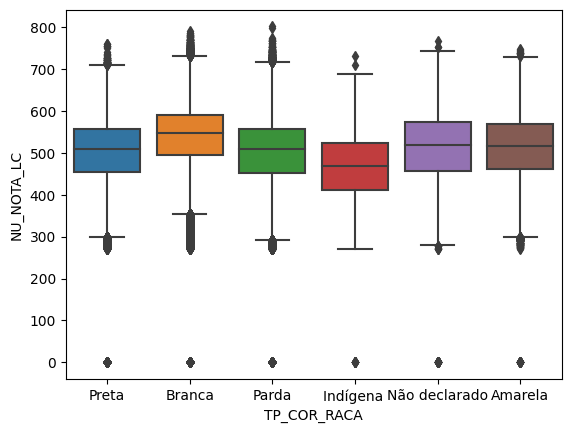

Kruskal-Wallis para MT = KruskalResult(statistic=939.4684042589519, pvalue=7.630556626701336e-201)


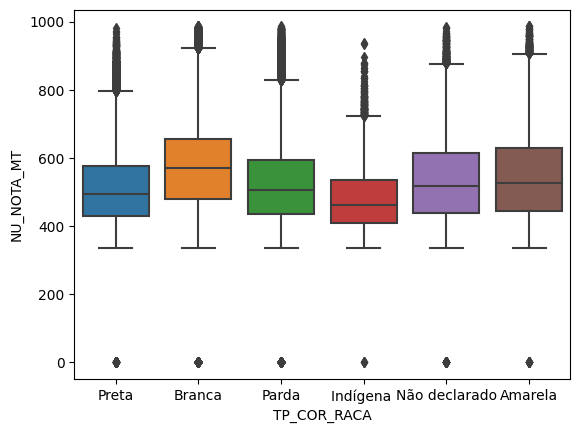

Kruskal-Wallis para REDACAO = KruskalResult(statistic=702.8686964577805, pvalue=1.177563309043664e-149)


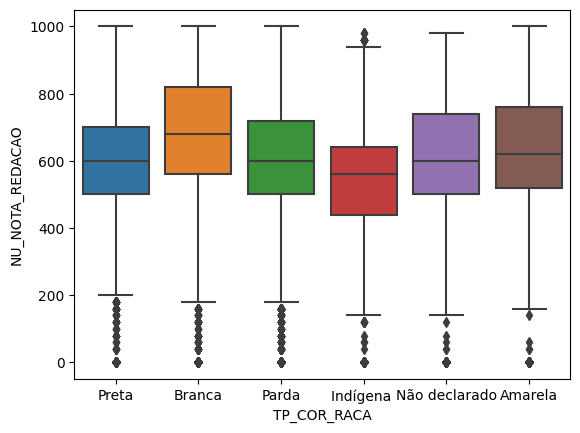

In [120]:
for name in ['CN', 'CH', 'LC', 'MT', 'REDACAO']:
    notas_cor = []
    for cor in enemx['TP_COR_RACA'].unique():
        aux = enemx.loc[(enemx['TP_COR_RACA'] == cor) & (enemx['NU_NOTA_' + name] > 200) , 'NU_NOTA_'+name]
        if aux.shape[0] > 2_500:
            aux = aux.sample(2_500)
        notas_cor.append(aux)
    print(f'Kruskal-Wallis para {name} = {stats.kruskal(*notas_cor)}')
    sns.boxplot(data=enemx, x='TP_COR_RACA', y='NU_NOTA_'+name)
    plt.show()

Por fim, aplicamos uma análise estatística para ver se questões socio-econômicas, como idade cor/raça, podem afetar a notas. Vemos que sim. Isso pode estar ligado a diferentes fatores, um exemplo disso poderia ser renda ou acesso a internet, como vemos a seguir

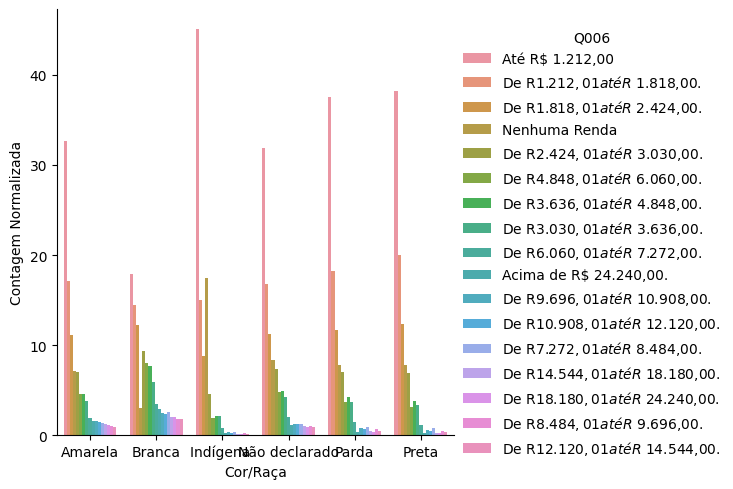

In [138]:
group =  enemx.groupby('TP_COR_RACA')['Q006'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(x='TP_COR_RACA', y='percent', hue='Q006', kind='bar', data=group)
plt.xlabel('Cor/Raça')
plt.ylabel("Contagem Normalizada")
plt.show()

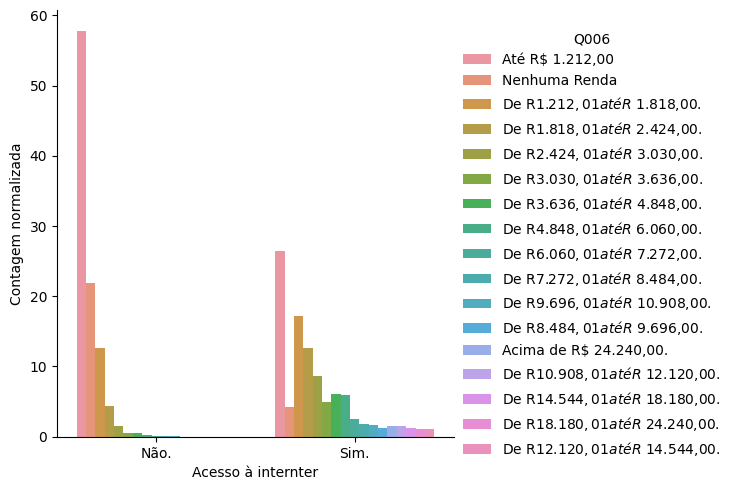

In [141]:
group =  enemx.groupby('Q025')['Q006'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(x='Q025', y='percent', hue='Q006', kind='bar', data=group)
plt.xlabel('Acesso à internter')
plt.ylabel("Contagem normalizada")
plt.show()

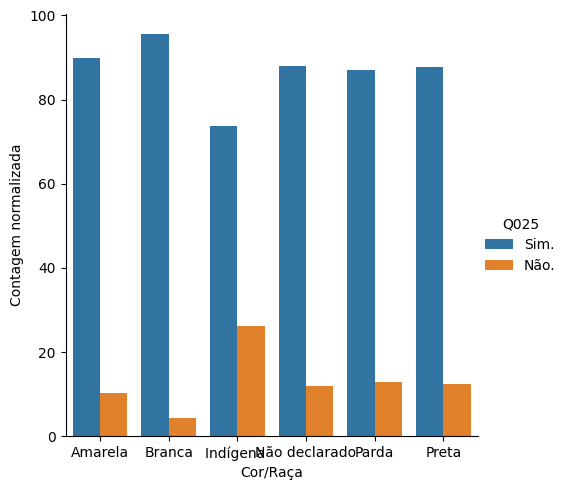

In [142]:
group =  enemx.groupby('TP_COR_RACA')['Q025'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(x='TP_COR_RACA', y='percent', hue='Q025', kind='bar', data=group)
plt.xlabel('Cor/Raça')
plt.ylabel("Contagem normalizada")
plt.show()

Fica fácil ver por meio desses gráficos que estões socio-econômicas, como renda, estão relacionadas ao acesso a internet; e que questões como cor/raça também estão relacioandas à renda, o que acaba sendo uma variável latente que move as distribuições de nota. Algo similar acontece com sexo, que possui variáveis latentes não capturadas no dataset que afetam a distribuição das notas.

#### Bônus

Nesse final, fazemos uma análise das correlações entre as variáveis de notas do enem nas diferentes modalidades, ou seja, Ciências Naturais, Ciências Humanas, Linguagens, Matemática e Redação.

Temos que as variáveis do tipo `TX` estão relacionadas fortemente às notas também, já que essas são variáveis que, após computadas pela Teoria de Resposta ao Item (TRI, que utiliza métodos de otimização estatística, como EM para maximizar uma função de verossimilhança sobre variáveis latentes do problema, no processo do seu cálculo), resultam nos valores referentes às variáveis de nota. Mas essas variáveis por si só somente representam os vetores de respostas dos alunos; e, mesmo que sejam cruzados com os vetores de gabarito, ainda não temos acesso à nota final por conta do processo de calcular a TRI e porque as questões dependem da ordem dada pela cor da prova feita pelo aluno.

In [26]:
enemx.columns[35:45]

Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO'],
      dtype='object')

<Axes: >

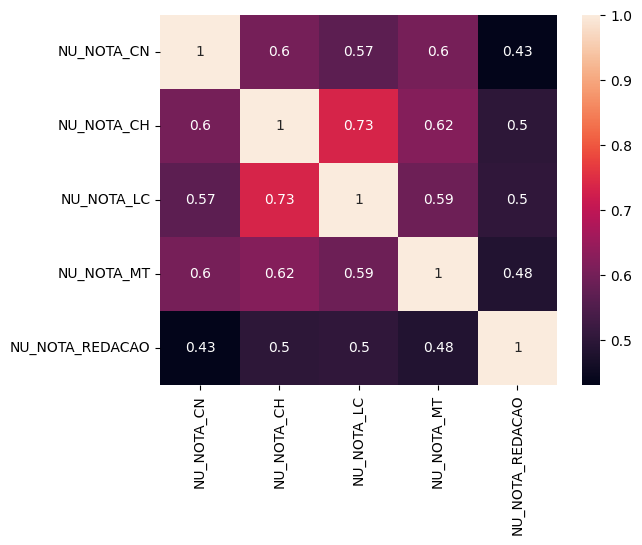

In [28]:
sns.heatmap(corr, annot=True)

Note que não usamos as notas das competências em redação porque elas claramente estão bem correlacionadas com a nota de redação, já que a nota de redação é composta pela soma das variáveis do tipo `NU_NOTA_COMPX`.

Ademais, podemos ver que linguagens está bem relacionado com redação, por meio de uma correlação linear. Além disso, as outras variáveis não parecem ser tão bem correlacionadas entre si. Uma análise mais aprofundade sobre esse fenômeno acontece na parte do projeto 2, que busca realizar uma regressão das notas de redação a partir das outras modalidades baseadas em provas de múltipla escolha.